In [2]:
from config import *
from functions import *
from sim_new import *
from read_ramses import *

from types import SimpleNamespace

# plotting
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
from scipy.ndimage import gaussian_filter
import matplotlib as mpl

# math
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import trapz, cumtrapz
from scipy.fft import fftn, fftfreq, fftshift
from scipy.signal.windows import blackman
from scipy.optimize import curve_fit, minimize, leastsq
from scipy.signal import welch
from scipy.special import erfc

# cosmology
from colossus.cosmology import cosmology
from colossus.lss import peaks
from colossus.lss import mass_function
cosmo = cosmology.setCosmology('planck18');
import const

# yt
import yt
from yt.visualization.fixed_resolution import FixedResolutionBuffer


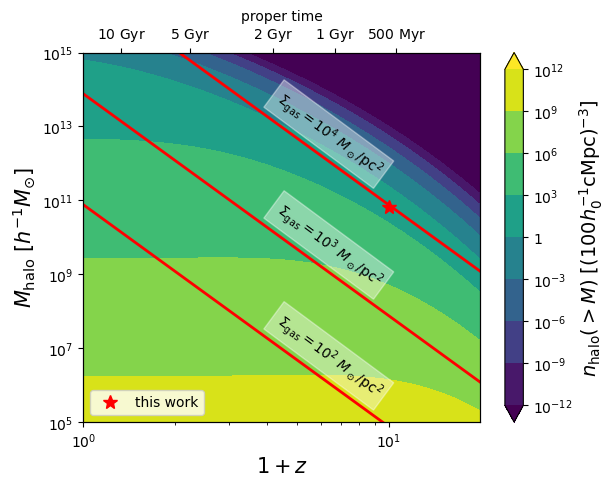

In [3]:
def calc_Mhalo(z, Sigma, lam=0.05, Delta=200):
    '''
    Halo mass for a given redshift and surface density.
    
    Args
        z: redshift
        Sigma: surface density
        lam: galaxy-to-halo radius ratio
        Delta: overdensity
    '''
    f_b = cosmo.Ob0 / cosmo.Om0
    Sigma = Sigma * const.M_sol / const.pc**2
    rho_c = cosmo.rho_c(0) * (const.M_sol * cosmo.h**2 / const.kpc**3)
    Mhalo = (Sigma * np.pi * lam**2 / (f_b * (1 + z)**2))**3 * (4*np.pi / 3 * Delta * rho_c * cosmo.Om0)**(-2)
    return Mhalo / (1/cosmo.h)

num = 512
zp1_list = np.logspace(0, 1.3, num)
M_list = np.logspace(5, 20, 2*num)
zp1_grid, M_grid = np.meshgrid(zp1_list-1, M_list)
n_halo = np.zeros((num, 2*num))
for i in range(num):
    dndlnM = mass_function.massFunction(M_list, zp1_list[i]-1, q_in='M', q_out='dndlnM')
    nu = peaks.peakHeight(M_list, zp1_list[i]-1)
    #nu = peaks.peakHeight(M_list, zp1_list[i]-1)
    #num[i] = erfc(nu / np.sqrt(2))
    n_halo[i] = cumtrapz(dndlnM[::-1], -np.log(M_list)[::-1], initial=0)[::-1]
n_halo *= 100**3

im = plt.contourf(zp1_list, M_list, np.log10(n_halo+1e-30).T, levels=np.arange(-12, 15, 3), cmap='viridis', extend='both')
#plt.contour(zp1_list, M_list, num, levels=[1, 5**3], colors='black')

for Sigma in [1e2, 1e3, 1e4]:
    Mhalo = calc_Mhalo(zp1_list-1, Sigma, lam=0.05) / const.M_sol
    plt.plot(zp1_list, Mhalo, lw=2, color='red')
    idx = np.argmin(np.abs(zp1_list-6))
    plt.annotate(r'$\Sigma_{\rm gas} = 10^{%d}~M_\odot/{\rm pc^2}$' % np.log10(Sigma), xy=(zp1_list[idx]/1.45, Mhalo[idx]/3), rotation=-36.5, fontsize=10, backgroundcolor=(1, 1, 1, 0.4))

tick_labels = ["$10^{-12}$", "$10^{-9}$", "$10^{-6}$", "$10^{-3}$", "$1$", "$10^3$", "$10^6$", "$10^9$", "$10^{12}$"]
cbar = plt.colorbar(im)
cbar.ax.set_yticklabels(tick_labels)
cbar.set_label(r'$n_{\rm halo}(>M)$ [$(100 h_0^{-1} {\rm cMpc})^{-3}$]', fontsize=14)

plt.xscale('log')
plt.yscale('log')
plt.xlim(10**0, 10**1.3)
plt.ylim(1e5, 1e15)
plt.xlabel(r'$1 + z$', fontsize=15)
plt.ylabel(r'$M_{\rm halo}$ [$h^{-1} M_{\odot}$]', fontsize=15)

ax2 = plt.gca().twiny()
ax2.set_xscale('log')
ax2.set_xlabel('proper time')

aexp_list = np.linspace(1e-3, 1., 2**10)
time_list = np.array([aexp_to_proper_time(aexp_list[i], Omega_m0=cosmo.Om0, Omega_k0=cosmo.Ok0, Omega_L0=cosmo.Ode0, H0=cosmo.H0*const.km/const.Mpc) for i in range(len(aexp_list))])
proper_time_to_aexp_interp = interp1d(time_list, aexp_list, fill_value='extrapolate')

time_ticks = np.array([500, 1000, 2000, 5000, 10000])*const.Myr
zp1_ticks = 1/proper_time_to_aexp_interp(time_ticks)

ax2.set_xticks(zp1_ticks)
ax2.minorticks_off()
ax2.set_xticklabels([r'$500~{\rm Myr}$', r'$1~{\rm Gyr}$', r'$2~{\rm Gyr}$', r'$5~{\rm Gyr}$', r'$10~{\rm Gyr}$'])
ax2.set_xlim(1, 10**(1.3))

plt.plot(9+1, 1e11*cosmo.h, marker='*', color='red', ms=10, linestyle='', label='this work')
#plt.plot(Katzp23.z+1, Katzp23.Mhalo_max*cosmo.h, color='black', lw=2, label=r'Sphinx')

plt.legend(loc=3)

#save_fig("haloregime")


In [102]:
from read_ramses import get_halo_cat


In [155]:
cat = get_halo_cat(50, cgs=True)


In [166]:
"%.3g" % (np.sort(cat.mass)[-1]/const.M_sol)


'5.57e+11'

Saved figure as 'mff-091120241714.png'


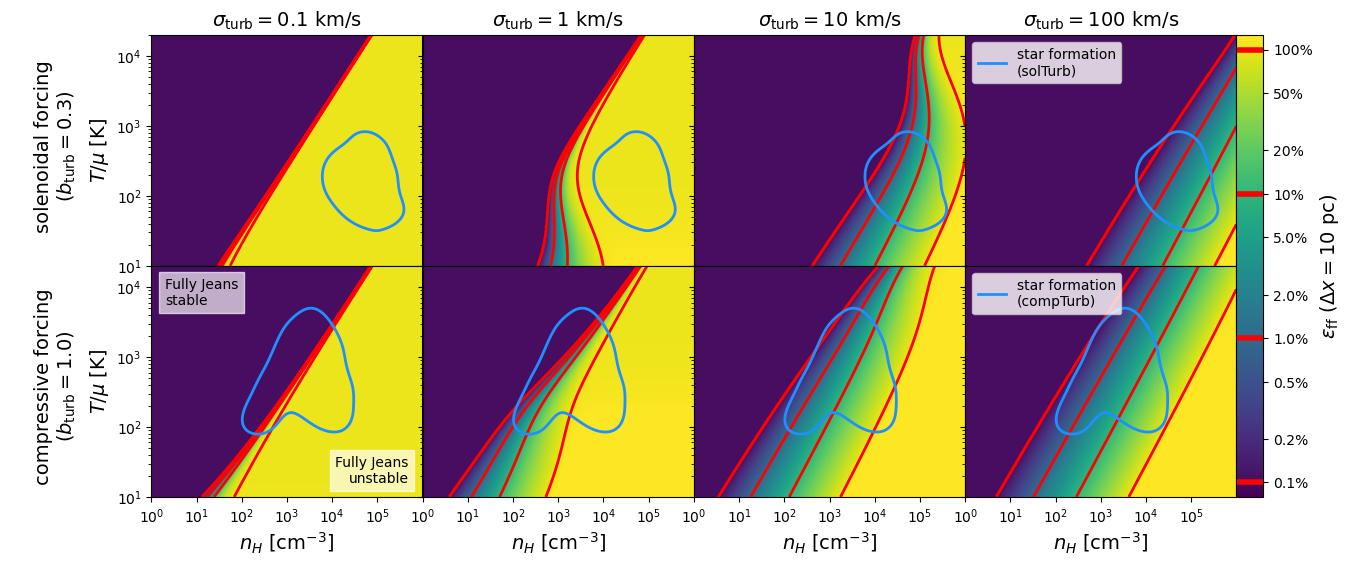

In [5]:
num = 512
dx = 10*const.pc
vel_turb = 100*const.km
b_turb = 0.3
frac = 0.9
sig = 10

nH_extrema = (1e0, 1e6)
temp_extrema = (1e1, 2e4)

nH_1d = np.logspace(*np.log10(nH_extrema), num)
temp_1d = np.logspace(*np.log10(temp_extrema), num)
nH, temp = np.meshgrid(nH_1d, temp_1d)
rho = nH*const.m_p

fig, axs = plt.subplots(ncols=4, nrows=2, sharex=True, sharey=True, figsize=(14, 6))
plt.subplots_adjust(hspace=1e-3, wspace=1e-3)

axs[0, 0].set_xscale('log')
axs[0, 0].set_yscale('log')

eps_sf_levels = np.array([0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1])
vel_turb_list = np.array([1e-1, 1e0, 1e1, 1e2]) * const.km
b_turb_list = np.array([0.3, 1.0])
   
for i, vel_turb in enumerate(vel_turb_list):
    for j, b_turb in enumerate(b_turb_list):
        ax = axs[j, i]
        eps_sf = calc_eps_sf2(rho, 3/2 * vel_turb**2, temp, dx, b_turb=b_turb)
        eps_sf[eps_sf < 1e-3] = 1e-3
        ax.contour(nH, temp, eps_sf, levels=[1e-3, 1e-2, 1e-1, 1e0], linewidths=2, colors='red')
        im = ax.pcolormesh(nH, temp, np.log10(eps_sf), vmin=-3.1, vmax=0.1, cmap='viridis')
        ax.set_xlim(*nH_extrema)
        ax.set_ylim(*temp_extrema)
    axs[0, i].set_title(r'$\sigma_{\rm turb} = %.3g~{\rm km/s}$'%(vel_turb/const.km), fontsize=14)

sim_dir = move_to_sim_dir(9, "fiducial", do_print=False)
data = SimpleNamespace(**np.load('starcat/data.npz'))
hist_sm = gaussian_filter(data.nH_temp_hist2d, sig)
field = hist_sm.flatten()
idx_sorted = np.argsort(field)
cumsum = np.cumsum(field[idx_sorted])
level = field[idx_sorted[np.searchsorted(cumsum, (1-frac)*cumsum[-1])]]
for i, vel_turb in enumerate(vel_turb_list):    
    axs[1, i].contour(data.nH2d, data.temp2d, hist_sm.T, levels=[level], colors='dodgerblue', linewidths=2)

sim_dir = move_to_sim_dir(9, "bturb0p3", do_print=False)
data = SimpleNamespace(**np.load('starcat/data.npz'))
hist_sm = gaussian_filter(data.nH_temp_hist2d, sig)
field = hist_sm.flatten()
idx_sorted = np.argsort(field)
cumsum = np.cumsum(field[idx_sorted])
level = field[idx_sorted[np.searchsorted(cumsum, (1-frac)*cumsum[-1])]]
for i, vel_turb in enumerate(vel_turb_list):    
    axs[0, i].contour(data.nH2d, data.temp2d, hist_sm.T, levels=[level], colors='dodgerblue', linewidths=2)
    
cax = axs[1, 3].inset_axes([1, 0, 0.1, 2])
cbar = plt.colorbar(im, cax=cax, ticks=np.log10(eps_sf_levels))
cbar.set_ticklabels(["0.1%", "0.2%", "0.5%", "1.0%", "2.0%", "5.0%", "10%", "20%", "50%", "100%"])
cbar.set_label(r'$\epsilon_{\rm ff}$ ($\Delta x = 10~{\rm pc}$)', fontsize=14)
for i in [-3, -2, -1, 0]: cax.axhline(y=i, color='red', lw=4)

for i in range(2): axs[i, 0].set_ylabel(r"$T/\mu$ [${\rm K}$]", fontsize=14)
for i in range(4): axs[1, i].set_xlabel(r"$n_H$ [${\rm cm^{-3}}$]", fontsize=14)
axs[0, 0].set_xticks([1e0, 1e1, 1e2, 1e3, 1e4, 1e5])

epssf_lines = [Line2D([0], [0], color='C0', lw=2), Line2D([0], [0], color='C1', lw=2), Line2D([0], [0], color='C2', lw=2), Line2D([0], [0], color='C3', lw=2)]
bturb_lines = [Line2D([0], [0], color='black', lw=2, linestyle='-'), Line2D([0], [0], color='black', lw=2, linestyle='--')]
sigma_lines = [Line2D([0], [0], color='grey', lw=2, linestyle='-')]

pos1 = (0.05, 0.95)
pos2 = (0.95, 0.05)
axs[1, 0].annotate("Fully Jeans\nstable", xy=pos1, xycoords='axes fraction', color='black', backgroundcolor=(1, 1, 1, 2/3), va='top', ha='left')
axs[1, 0].annotate("Fully Jeans\nunstable", xy=pos2, xycoords='axes fraction', color='black', backgroundcolor=(1, 1, 1, 2/3), va='bottom', ha='right')

plt.annotate('solenoidal forcing\n' + r'($b_{\rm turb} = 0.3$)', xy=(0.04, 0.7), xycoords="figure fraction", fontsize=14, horizontalalignment='center', verticalalignment='center', rotation=90)
plt.annotate('compressive forcing\n' + r'($b_{\rm turb} = 1.0$)', xy=(0.04, 0.3), xycoords="figure fraction", fontsize=14, horizontalalignment='center', verticalalignment='center', rotation=90)

cust_lines = [Line2D([0], [0], color='dodgerblue', lw=2, linestyle='-')]
axs[0, 3].legend(cust_lines, ['star formation\n(solTurb)'], fontsize=10, loc=2)
axs[1, 3].legend(cust_lines, ['star formation\n(compTurb)'], fontsize=10, loc=2)

save_fig("mff")


In [4]:
sim_round = 9
sim_name = "fiducial"
sim_dir = move_to_sim_dir(sim_round, sim_name)
dump = get_dump(aexp=0.1)
info = get_info(dump)
coord_center_code = np.array([0.51052355, 0.51274707, 0.49298533])
coord_center = coord_center_code*info.length_unit
info_file = os.path.join("output_%.5d" % dump, "info_%.5d.txt" % dump)
ds = yt.load(info_file)


yt : [INFO     ] 2025-01-22 13:58:06,601 Parameters: current_time              = 4.033945983367195
yt : [INFO     ] 2025-01-22 13:58:06,601 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2025-01-22 13:58:06,602 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2025-01-22 13:58:06,602 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2025-01-22 13:58:06,603 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2025-01-22 13:58:06,603 Parameters: current_redshift          = 9.135272563306033
yt : [INFO     ] 2025-01-22 13:58:06,603 Parameters: omega_lambda              = 0.723999977111816
yt : [INFO     ] 2025-01-22 13:58:06,603 Parameters: omega_matter              = 0.275999993085861
yt : [INFO     ] 2025-01-22 13:58:06,604 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2025-01-22 13:58:06,604 Parameters: hubble_constant           = 0.703000030517578


In [7]:
particle_type = ds["io", "particle_family"].value.astype(int)
is_dm = particle_type == DM

coord_dm_code = (np.array([data["io", "particle_position_x"].value[is_dm], data["io", "particle_position_y"].value[is_dm], data["io", "particle_position_z"].value[is_dm]]))
mass_dm_code = data["io", "particle_mass"][is_dm].value


KeyError: ('io', 'particle_family')

yt : [INFO     ] 2025-01-08 10:56:33,153 Projection completed
yt : [INFO     ] 2025-01-08 10:56:33,155 xlim = 0.492875 0.507125
yt : [INFO     ] 2025-01-08 10:56:33,155 ylim = 0.492875 0.507125
yt : [INFO     ] 2025-01-08 10:56:33,157 xlim = 0.492875 0.507125
yt : [INFO     ] 2025-01-08 10:56:33,158 ylim = 0.492875 0.507125
yt : [INFO     ] 2025-01-08 10:56:33,159 Making a fixed resolution buffer of (('ramses', 'Density')) 512 by 512
yt : [INFO     ] 2025-01-08 10:56:33,310 xlim = 0.503398 0.517649
yt : [INFO     ] 2025-01-08 10:56:33,311 ylim = 0.505622 0.519872
yt : [INFO     ] 2025-01-08 10:56:33,312 Making a fixed resolution buffer of (('ramses', 'Density')) 512 by 512



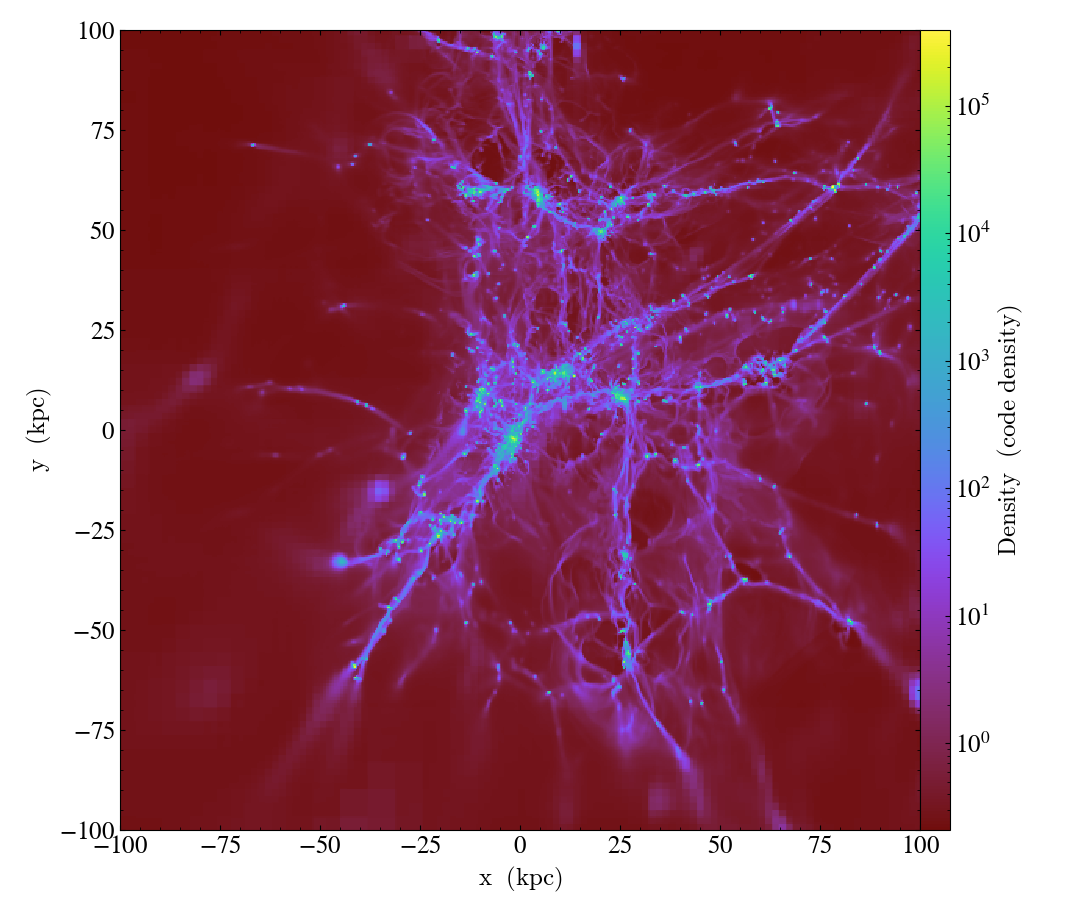

In [18]:
from yt.units import kpc
prj = yt.ProjectionPlot(
    ds,
    "z",
    ("ramses", "Density"),
    width=200*kpc,
    weight_field=("ramses", "Density"),
    buff_size=(512, 512),
)
prj.set_center((coord_center_code[0], coord_center_code[1]))


In [15]:
num = 512
left_corn_code_list = []
right_corn_code_list = []
density_list = []
box_size_list = [100*const.Mpc/const.h0*info.aexp, 10*const.Mpc/const.h0*info.aexp, 1*const.Mpc/const.h0*info.aexp, 100*const.kpc/const.h0*info.aexp, 10*const.kpc/const.h0*info.aexp]

sl = ds.slice(Z, coord_center_code[Z])
bounds = (0, 1, 0, 1)
frb = FixedResolutionBuffer(sl, bounds, (num, num))
density_list.append(frb["density"].value)

for box_size in box_size_list[1:]:
    box_size_code = box_size/info.length_unit
    left_corn_code_list.append(coord_center_code-box_size_code/2)
    right_corn_code_list.append(coord_center_code+box_size_code/2)
    bounds = (left_corn_code_list[-1][X], right_corn_code_list[-1][X], left_corn_code_list[-1][Y], right_corn_code_list[-1][Y])
    frb = FixedResolutionBuffer(sl, bounds, (num, num))
    density_list.append(frb["density"].value)


yt : [INFO     ] 2024-05-30 11:28:57,947 Making a fixed resolution buffer of (density) 512 by 512
yt : [INFO     ] 2024-05-30 11:29:46,115 Adding particle_type: DM
yt : [INFO     ] 2024-05-30 11:29:46,128 Adding particle_type: star
yt : [INFO     ] 2024-05-30 11:29:46,138 Adding particle_type: cloud
yt : [INFO     ] 2024-05-30 11:29:46,148 Adding particle_type: dust
yt : [INFO     ] 2024-05-30 11:29:46,160 Adding particle_type: star_tracer
yt : [INFO     ] 2024-05-30 11:29:46,172 Adding particle_type: cloud_tracer
yt : [INFO     ] 2024-05-30 11:29:46,182 Adding particle_type: dust_tracer
yt : [INFO     ] 2024-05-30 11:29:46,193 Adding particle_type: gas_tracer
yt : [INFO     ] 2024-05-30 11:30:08,693 Making a fixed resolution buffer of (density) 512 by 512


Saved figure as 'zoom-053020241130.png'


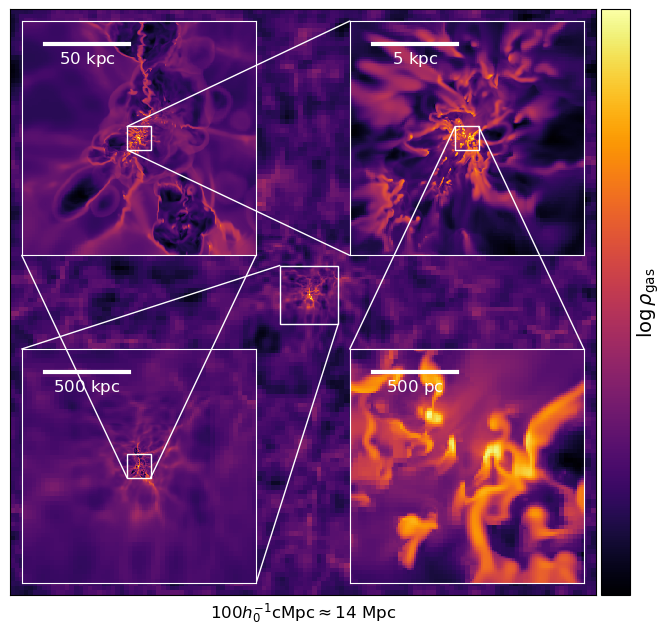

In [16]:
fig, ax1 = plt.subplots(figsize=(8, 8))
ax1.set_aspect(True)

x, y = np.meshgrid(np.linspace(0, 1, num), np.linspace(0, 1, num))
im = ax1.pcolormesh(x, y, np.log10(density_list[0]), cmap='inferno')
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel(r'$100 h_0^{-1} {\rm cMpc} \approx 14~{\rm Mpc}$', fontsize=12)

edge_space = 0.02
inset_size = 0.4
boundary_list = [[edge_space, edge_space, inset_size, inset_size], [edge_space, 1-edge_space-inset_size, inset_size, inset_size], [1-edge_space-inset_size, 1-edge_space-inset_size, inset_size, inset_size], [1-edge_space-inset_size, edge_space, inset_size, inset_size]]
dis_label_list = [r'$500~{\rm kpc}$', r'$50~{\rm kpc}$', r'$5~{\rm kpc}$', r'$500~{\rm pc}$']

axprev = ax1
for i in range(len(box_size_list)-1):
    box_size_code = box_size_list[i+1]/info.length_unit
    left_corn = left_corn_code_list[i]
    right_corn = right_corn_code_list[i]
    x, y = np.meshgrid(np.linspace(left_corn[X], right_corn[X], num), np.linspace(left_corn[Y], right_corn[Y], num))
    axin = ax1.inset_axes(boundary_list[i], xlim=(left_corn[X], right_corn[X]), ylim=(left_corn[Y], right_corn[Y]), xticklabels=[], yticklabels=[])
    axin.plot([left_corn[X]+0.1*box_size_code, left_corn[X]+0.457*box_size_code], [right_corn[Y]-0.1*box_size_code, right_corn[Y]-0.1*box_size_code], lw=3, color='white')
    axin.annotate(dis_label_list[i], (left_corn[X]+0.279*box_size_code, right_corn[Y]-0.12*box_size_code), color='white', horizontalalignment='center', verticalalignment='top', fontsize=12)
    axin.pcolormesh(x, y, np.log10(density_list[i+1]), cmap='inferno')
    axprev.indicate_inset_zoom(axin, edgecolor="white", alpha=1.)
    plt.setp(axin.spines.values(), color='white')
    axin.set_xticks([])
    axin.set_yticks([])
    axprev = axin

divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(im, ax=ax1, cax=cax, ticks=[])
cbar.set_label(r'$\log \rho_{\rm gas}$', fontsize=14)

save_fig("zoom")


In [56]:
sim_round = 9
sim_name = "bturbfunc"
sim_dir = move_to_sim_dir(sim_round, sim_name)
dump = get_dump(aexp=0.1)
info = get_info(dump)
coord_center_code = np.array([0.51051653, 0.51275925, 0.49299356])
coord_center = coord_center_code*info.length_unit
info_file = os.path.join("output_%.5d" % dump, "info_%.5d.txt" % dump)
ds = yt.load(info_file)


Moving to directory '/home/za9132/scratch/romain/round9/bturbfunc'.


yt : [INFO     ] 2024-04-19 09:17:13,523 Parameters: current_time              = 4.0069482754088295
yt : [INFO     ] 2024-04-19 09:17:13,524 Parameters: domain_dimensions         = [128 128 128]
yt : [INFO     ] 2024-04-19 09:17:13,524 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2024-04-19 09:17:13,525 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2024-04-19 09:17:13,525 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2024-04-19 09:17:13,526 Parameters: current_redshift          = 8.999966450737556
yt : [INFO     ] 2024-04-19 09:17:13,526 Parameters: omega_lambda              = 0.723999977111816
yt : [INFO     ] 2024-04-19 09:17:13,526 Parameters: omega_matter              = 0.275999993085861
yt : [INFO     ] 2024-04-19 09:17:13,526 Parameters: omega_radiation           = 0.0
yt : [INFO     ] 2024-04-19 09:17:13,526 Parameters: hubble_constant           = 0.703000030517578


In [57]:
def _vorticity_x_new(field, data): return data["gas", "velocity_z_gradient_y"] - data["gas", "velocity_y_gradient_z"]
def _vorticity_y_new(field, data): return data["gas", "velocity_x_gradient_z"] - data["gas", "velocity_z_gradient_x"]
def _vorticity_z_new(field, data): return data["gas", "velocity_y_gradient_x"] - data["gas", "velocity_x_gradient_y"]
def _vorticity_magnitude(field, data): return np.sqrt(data["gas", "vorticity_x_new"]**2 + data["gas", "vorticity_y_new"]**2 + data["gas", "vorticity_z_new"]**2)
def _velocity_divergence_new(field, data): return data["gas", "velocity_x_gradient_x"] + data["gas", "velocity_y_gradient_y"] + data["gas", "velocity_z_gradient_z"]
def _bturb(field, data): return (1./3. + 2./3. * (data["gas", "velocity_divergence_new"]**2 / (data["gas", "vorticity_magnitude"]**2 + data["gas", "velocity_divergence_new"]**2))**3)

fields_to_add = {
    "vorticity_x_new": {"function": _vorticity_x_new, "units": "1/s"},
    "vorticity_y_new": {"function": _vorticity_y_new, "units": "1/s"},
    "vorticity_z_new": {"function": _vorticity_z_new, "units": "1/s"},
    "vorticity_magnitude": {"function": _vorticity_magnitude, "units": "1/s"},
    "velocity_divergence_new": {"function": _velocity_divergence_new, "units": "1/s"},
    "bturb": {"function": _bturb, "units": ""}
}

ds.add_gradient_fields(("gas", "velocity_x"))
ds.add_gradient_fields(("gas", "velocity_y"))
ds.add_gradient_fields(("gas", "velocity_z"))
for field_name, field_data in fields_to_add.items():
    ds.add_field(name=("gas", field_name), function=field_data['function'], sampling_type="local", units=field_data['units'], force_override=True)


yt : [WARNING  ] 2024-04-19 09:17:50,169 The DM particle filter already exists. Overriding.
yt : [WARNING  ] 2024-04-19 09:17:50,171 The star particle filter already exists. Overriding.
yt : [WARNING  ] 2024-04-19 09:17:50,171 The cloud particle filter already exists. Overriding.
yt : [WARNING  ] 2024-04-19 09:17:50,171 The dust particle filter already exists. Overriding.
yt : [WARNING  ] 2024-04-19 09:17:50,171 The star_tracer particle filter already exists. Overriding.
yt : [WARNING  ] 2024-04-19 09:17:50,172 The cloud_tracer particle filter already exists. Overriding.
yt : [WARNING  ] 2024-04-19 09:17:50,172 The dust_tracer particle filter already exists. Overriding.
yt : [WARNING  ] 2024-04-19 09:17:50,172 The gas_tracer particle filter already exists. Overriding.
yt : [INFO     ] 2024-04-19 09:17:50,172 Adding particle_type: DM
yt : [INFO     ] 2024-04-19 09:17:50,183 Adding particle_type: star
yt : [INFO     ] 2024-04-19 09:17:50,192 Adding particle_type: cloud
yt : [INFO     ] 2

In [58]:
num = 512
box_size_list = [100*const.kpc, 10*const.kpc]

sl = ds.slice(Z, coord_center_code[Z])
div, curl, bturb, vx, vy = [], [], [], [], []
for box_size in box_size_list:
    box_size_code = box_size/info.length_unit
    bounds = (coord_center_code[X]-box_size_code/2, coord_center_code[X]+box_size_code/2, coord_center_code[Y]-box_size_code/2, coord_center_code[Y]+box_size_code/2)
    frb = FixedResolutionBuffer(sl, bounds, (num, num))
    div.append(np.abs(frb["velocity_divergence_new"].value))
    curl.append(frb["vorticity_magnitude"].value)
    bturb.append(frb["bturb"].value)
    vx.append(frb["velocity_x"])
    vy.append(frb["velocity_y"])


yt : [INFO     ] 2024-04-19 09:17:58,473 Making a fixed resolution buffer of (velocity_divergence_new) 512 by 512
yt : [WARNING  ] 2024-04-19 09:18:12,527 RAMSESDomainSubset (info_00047): , base_region=YTSlice (info_00047): , axis=2, coord=0.49299356, domain=RAMSESDomainFile: 1, ds=info_00047.retrieve_ghost_zones was called with the `smoothed` argument set to True. This is not supported, ignoring it.
yt : [WARNING  ] 2024-04-19 09:18:12,719 RAMSESDomainSubset (info_00047): , base_region=YTSlice (info_00047): , axis=2, coord=0.49299356, domain=RAMSESDomainFile: 6, ds=info_00047.retrieve_ghost_zones was called with the `smoothed` argument set to True. This is not supported, ignoring it.
yt : [WARNING  ] 2024-04-19 09:18:12,749 RAMSESDomainSubset (info_00047): , base_region=YTSlice (info_00047): , axis=2, coord=0.49299356, domain=RAMSESDomainFile: 9, ds=info_00047.retrieve_ghost_zones was called with the `smoothed` argument set to True. This is not supported, ignoring it.
yt : [WARNING  ]

Saved figure as 'bturb-041920240920.png'


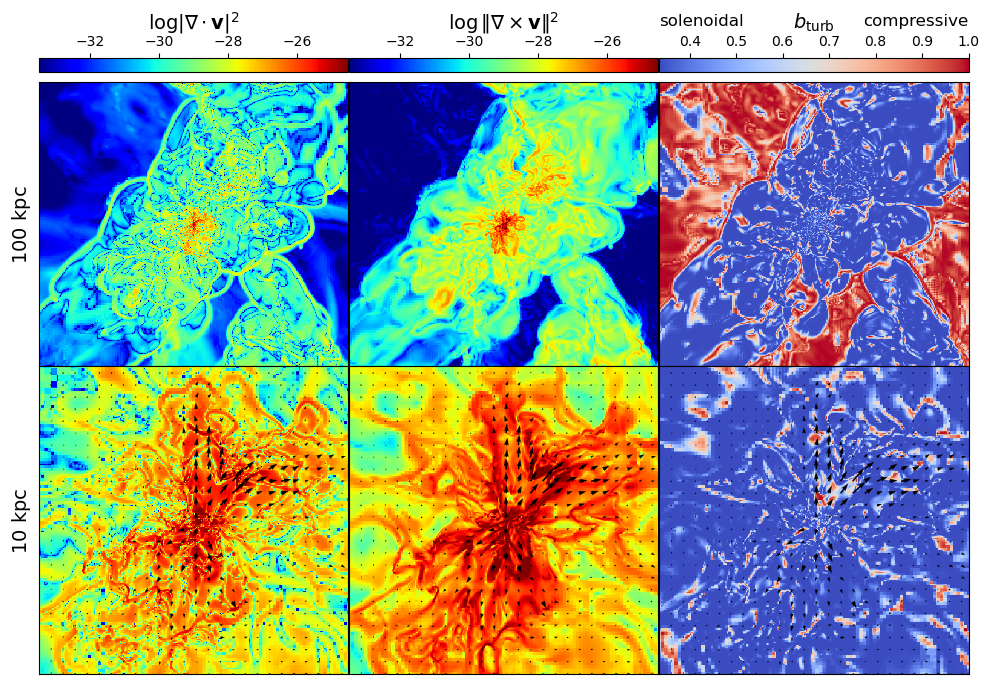

In [65]:
skip = 20

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))
plt.subplots_adjust(hspace=1e-3, wspace=1e-3)

for i in range(2):
    x, y = np.meshgrid(np.linspace(-box_size_list[i]/const.kpc/2, box_size_list[i]/const.kpc/2, num), np.linspace(-box_size_list[i]/const.kpc/2, box_size_list[i]/const.kpc/2, num))
    im1 = axs[i, 0].pcolormesh(x, y, np.log10(div[i]**2), vmin=-33.5, vmax=-24.5, cmap='jet')
    im2 = axs[i, 1].pcolormesh(x, y, np.log10(curl[i]**2), vmin=-33.5, vmax=-24.5, cmap='jet')
    im3 = axs[i, 2].pcolormesh(x, y, bturb[i], vmin=1/3, vmax=1., cmap='coolwarm')
    
label_list = [r'$\log |\nabla \cdot \mathbf{v}|^2$', r'$\log \|\nabla \times \mathbf{v}\|^2$', r'$b_{\rm turb}$']
    
for i in range(3): 
    divider = make_axes_locatable(axs[0, i])
    cax = divider.append_axes("top", size="5%", pad=0.1)
    cbar = plt.colorbar([im1, im2, im3][i], ax=axs[0, i], cax=cax, orientation="horizontal")
    cbar.set_label(label_list[i], fontsize=14)
    cax.xaxis.set_ticks_position("top")
    cax.xaxis.set_label_position("top")
    axs[0, i].set_xticks([])
    axs[0, i].set_yticks([])
    axs[1, i].set_xticks([])
    axs[1, i].set_yticks([])
    axs[1, i].quiver(x[::skip, ::skip], y[::skip, ::skip], vx[1].value[::skip, ::skip], vy[1].value[::skip, ::skip], scale=7e9, width=0.005)
    
axs[0, 0].set_ylabel(r'$100~{\rm kpc}$', fontsize=14)
axs[1, 0].set_ylabel(r'$10~{\rm kpc}$', fontsize=14)

axs[0, 2].annotate('solenoidal', (0, 1.2), xycoords='axes fraction', fontsize=12)
axs[0, 2].annotate('compressive', (0.66, 1.2), xycoords='axes fraction', fontsize=12)

save_fig('bturb')


In [17]:
sim_list_list = [[(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0"), (12, "nophot"), (11, "mstar0p2"), (11, "mstar1p0"), (11, "mstar5p0")], [(9, "instantfeedback"), (9, "fastfeedback"), (9, "fiducial")], [(9, "bturb0p3"), (9, "bturbfunc"), (9, "fiducial")]]
npz_list_list = [["data_d47_l1_b5.npz", "data_d52_l1_b5.npz", "data_d45_l1_b5.npz", "data_d53_l1_b5.npz", "data_d51_l1_b5.npz", "data_d51_l1_b5.npz", "data_d49_l1_b5.npz"], ["data_d48_l1_b5.npz", "data_d52_l1_b5.npz", "data_d52_l1_b5.npz"], ["data_d45_l1_b5.npz", "data_d47_l1_b5.npz", "data_d52_l1_b5.npz"]]

dt = 0.1*const.Myr
nstep = 5583
eta = 0.2

window = np.zeros(2*nstep-1)
window[nstep:nstep+tstart_idx] = 1
window[nstep+tstart_idx:nstep+tend_idx] = np.linspace(1, 1-eta, tend_idx-tstart_idx)
window[nstep+tend_idx:] = 1-eta
window *= dt

SFR_list = [[np.zeros(nstep), np.zeros(nstep), np.zeros(nstep), np.zeros(nstep), np.zeros(nstep), np.zeros(nstep), np.zeros(nstep)], [np.zeros(nstep), np.zeros(nstep), np.zeros(nstep)], [np.zeros(nstep), np.zeros(nstep), np.zeros(nstep)]]
Mstar_list = [[np.zeros(nstep), np.zeros(nstep), np.zeros(nstep), np.zeros(nstep), np.zeros(nstep), np.zeros(nstep), np.zeros(nstep)], [np.zeros(nstep), np.zeros(nstep), np.zeros(nstep)], [np.zeros(nstep), np.zeros(nstep), np.zeros(nstep)]]

for i in range(3):
    
    sim_list, npz_list = sim_list_list[i], npz_list_list[i]
    nsim = len(sim_list)
    
    for j in range(nsim):
        
        sim_round, sim_name = sim_list[j]
        sim = Sim(sim_round, sim_name, npz_list[j])
        
        time, SFR = calc_hist1d(sim.time_starbirth, vmin=0, vmax=558.3*const.Myr, nbin=5583, weight=sim.mass_star, do_log=False)
        SFR[::-1][tstart_idx:tend_idx] *= 1/np.linspace(1, 1-eta, tend_idx-tstart_idx)
        SFR[::-1][tend_idx:] *= 1/(1-eta)
        SFR_list[i][j] = SFR
        Mstar_list[i][j] = np.convolve(SFR, window, mode='valid')
        
np.savez('/home/za9132/analysis/SFR', time=time, SFR_list=SFR_list, Mstar_list=Mstar_list)


Moving to directory '/home/za9132/scratch/romain/round9/mstar0p2'.
Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.
Moving to directory '/home/za9132/scratch/romain/round9/mstar5p0'.
Moving to directory '/home/za9132/scratch/romain/round12/nophot'.
Moving to directory '/home/za9132/scratch/romain/round11/mstar0p2'.
Moving to directory '/home/za9132/scratch/romain/round11/mstar1p0'.
Moving to directory '/home/za9132/scratch/romain/round11/mstar5p0'.
Moving to directory '/home/za9132/scratch/romain/round9/instantfeedback'.
Moving to directory '/home/za9132/scratch/romain/round9/fastfeedback'.
Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.
Moving to directory '/home/za9132/scratch/romain/round9/bturb0p3'.
Moving to directory '/home/za9132/scratch/romain/round9/bturbfunc'.
Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.


/usr/licensed/anaconda3/2023.3/lib/python3.10/site-packages/numpy/lib/npyio.py:716: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


In [3]:
dt = 0.1*const.Myr
nstep = 5583
eta = 0.2
data = np.load('/home/za9132/analysis/SFR.npz', allow_pickle=True)
time = data['time']
SFR_list = data['SFR_list']
Mstar_list = data['Mstar_list']


Saved figure as 'starmass-100920242001.png'


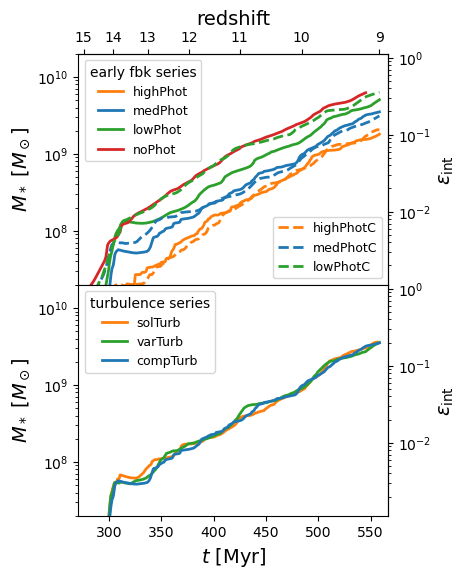

In [30]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(4, 6), sharey=True, sharex=True)
plt.subplots_adjust(hspace=1e-3, wspace=1e-3)

z_min = 15.2
z_max = 8.9
tick_z = [15, 14, 13, 12, 11, 10, 9]

aexp_list = np.linspace(1e-3, 1., 2**10)
time_list = np.array([aexp_to_proper_time(aexp_list[i]) for i in range(len(aexp_list))])
proper_time_to_z_interp = interp1d(time_list/const.Myr, 1/aexp_list-1, fill_value='extrapolate')
z_to_proper_time_interp = interp1d(1/aexp_list-1, time_list/const.Myr, fill_value='extrapolate')

sim_list_list = [[(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0"), (12, "nophot"), (11, "mstar0p2"), (11, "mstar1p0"), (11, "mstar5p0")], [(9, "bturb0p3"), (9, "bturbfunc"), (9, "fiducial")]]
label_list_list = [[r"highPhot", r"medPhot", r"lowPhot", "noPhot", None, None, None], [r"solTurb", r"varTurb", r"compTurb"]]
color_list_list = [["C1", "C0", "C2", "C3", "C1", "C0", "C2"], ["C1", "C2", "C0"]]
linestyle_list_list = [["-"]*4+["--"]*3, ["-"]*3]
is_mff_list_list = [[True]*4+[False]*3, [True]*3]

for j in range(2):
    
    sim_list, label_list, color_list, linestyle_list, is_mff_list = sim_list_list[j], label_list_list[j], color_list_list[j], linestyle_list_list[j], is_mff_list_list[j]
    
    for i in range(len(label_list)):
        
        sim_round, sim_name = sim_list[i]
        move_to_sim_dir(sim_round, sim_name, do_print=False)
        data = SimpleNamespace(**np.load('starcat/data.npz'))

        SFR, Mstar = SFR_list[j][i], Mstar_list[j][i]
        cond = (SFR > 0)
        axs[j].plot(time[cond]/const.Myr, Mstar[cond]/const.M_sol, lw=2., color=color_list[i], linestyle=linestyle_list[i])

axtop = axs[0].secondary_xaxis('top', functions=(proper_time_to_z_interp, z_to_proper_time_interp))
axtop.set_xticks(tick_z)
axtop.set_xlabel(r'redshift', fontsize=14)

for i in range(2):
    axs[i].set_xlabel(r"$t$ [Myr]", fontsize=14)
    axs[i].set_yscale('log')
    axs[i].set_xlim(z_to_proper_time_interp(z_min), z_to_proper_time_interp(z_max))
    axs[i].set_ylabel(r"$M_*$ [$M_\odot$]", fontsize=14)
    axs[i].set_ylim(2e7, 2e10)

cust_lines = [Line2D([0], [0], color=color, lw=2) for color in ["C1", "C0", "C2", "C3"]]
leg = axs[0].legend(cust_lines, label_list_list[0], fontsize=9, title="early fbk series")
cust_lines = [Line2D([0], [0], color=color, lw=2) for color in ["C1", "C2", "C0"]]
axs[1].legend(cust_lines, label_list_list[1], fontsize=9, title="turbulence series")
cust_lines = [Line2D([0], [0], color=color, linestyle="--", lw=2) for color in ["C1", "C0", "C2"]]
axs[0].legend(cust_lines, ['highPhotC', 'medPhotC', 'lowPhotC'], fontsize=9, loc=4)
axs[0].add_artist(leg)


M_halo = 1e11
f_b = const.Omega_b0 / const.Omega_m0
Mstar2epsint = lambda Mstar: Mstar / (f_b * M_halo)
epsint2Mstar = lambda epsint: epsint * f_b * M_halo

axright0 = axs[0].secondary_yaxis('right', functions=(Mstar2epsint, epsint2Mstar))
axright0.set_ylabel(r'$\varepsilon_{\rm int}$', fontsize=14)
axright0.set_yscale("log")
axright0.set_yticks([1e-2, 1e-1, 1e0])

axright1 = axs[1].secondary_yaxis('right', functions=(Mstar2epsint, epsint2Mstar))
axright1.set_ylabel(r'$\varepsilon_{\rm int}$', fontsize=14)
axright1.set_yticks([1e-2, 1e-1, 1e0]);

save_fig("starmass")


Saved figure as 'SFE_loc-090520241430.png'


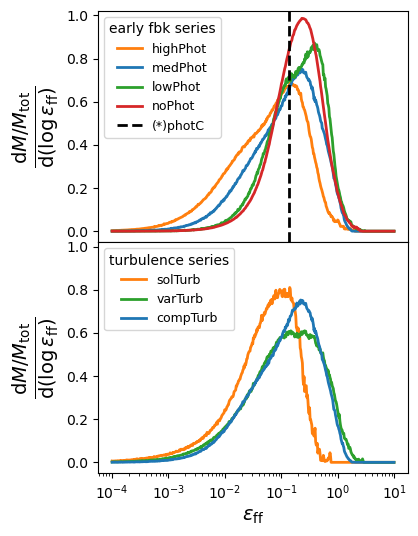

In [54]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(4, 6), sharey=True, sharex=True)
plt.subplots_adjust(hspace=1e-3, wspace=1e-3)

sim_list_list = [[(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0"), (12, "nophot"), (11, "mstar0p2"), (11, "mstar1p0"), (11, "mstar5p0")], [(9, "bturb0p3"), (9, "bturbfunc"), (9, "fiducial")]]
label_list_list = [[r"highPhot", r"medPhot", r"lowPhot", "noPhot", "highPhotC", "medPhotC", "lowPhotC"], [r"solTurb", r"varTurb", r"compTurb"]]
color_list_list = [["C1", "C0", "C2", "C3", "C1", "C0", "C2"], ["C1", "C2", "C0"]]
linestyle_list_list = [["-"]*4+["--"]*3, ["-"]*3]
is_mff_list_list = [[True]*4+[False]*3, [True]*3]

for j in range(2):
    
    sim_list, label_list, color_list, linestyle_list, is_mff_list = sim_list_list[j], label_list_list[j], color_list_list[j], linestyle_list_list[j], is_mff_list_list[j]
    
    for i in range(len(label_list)):
        
        sim_round, sim_name = sim_list[i]
        move_to_sim_dir(sim_round, sim_name, do_print=False)
        data = SimpleNamespace(**np.load('starcat/data.npz'))

        SFR, Mstar = SFR_list[j][i], Mstar_list[j][i]
        cond = (SFR > 0)
        if is_mff_list[i]: axs[j].plot(data.eps_sf1d, data.eps_sf_pdf1d, lw=2, color=color_list[i])
    
for i in range(2):
    axs[i].set_xscale('log')
    axs[i].set_xlabel(r"$\epsilon_{\rm ff}$", fontsize=14)
    axs[i].set_ylim(-0.05, 1.02)
    axs[i].set_ylabel(r'$\frac{{\rm d} M/M_{\rm tot}}{{\rm d}(\log \epsilon_{\rm ff})}$', fontsize=20)
axs[0].axvline(x=0.1371535430985907, color='black', linestyle='--', lw=2)

cust_lines = [Line2D([0], [0], color=color, lw=2) for color in ["C1", "C0", "C2", "C3"]] + [Line2D([0], [0], color='black', linestyle='--', lw=2)]
leg = axs[0].legend(cust_lines, label_list_list[0][:4] + ["(*)photC"], fontsize=9, title="early fbk series")
cust_lines = [Line2D([0], [0], color=color, lw=2) for color in ["C1", "C2", "C0"]]
axs[1].legend(cust_lines, label_list_list[1], fontsize=9, title="turbulence series")

#save_fig("SFE_loc")


/tmp/ipykernel_2336742/1828427468.py:40: RuntimeWarning: divide by zero encountered in log10
  log_SFR = np.log10(SFR)
/tmp/ipykernel_2336742/1828427468.py:46: RuntimeWarning: divide by zero encountered in divide
  axs[2, j].plot(1/freq/const.Myr, psd/const.Myr, lw=2, color=color_list[i], linestyle=linestyle_list[i])


Saved figure as 'variability-090520241439.png'


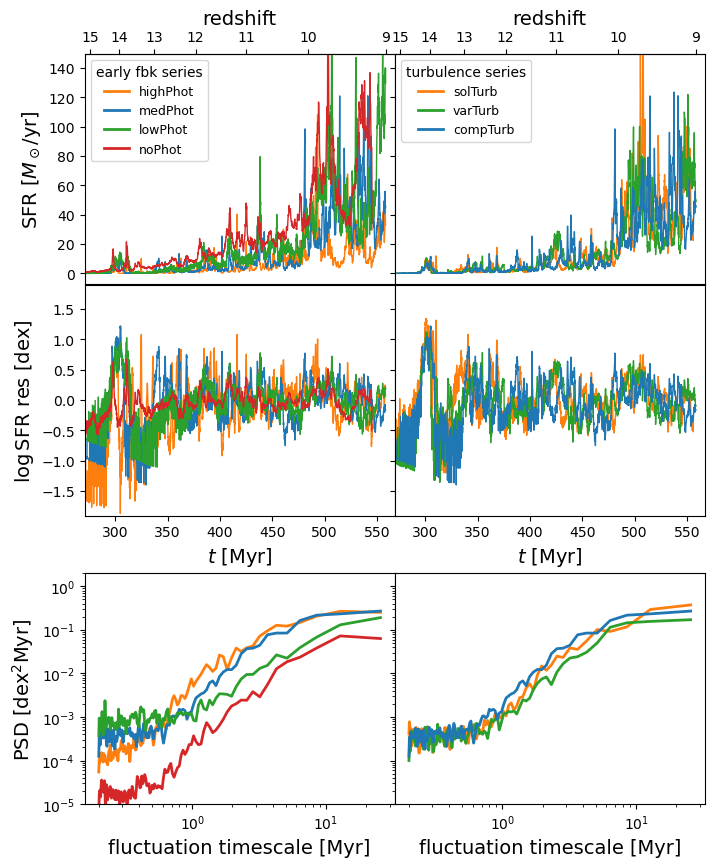

In [63]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6), sharey='row')
plt.subplots_adjust(hspace=1e-3, wspace=1e-3)

axs_new = np.zeros((3, 2), dtype=plt.Axes)
axs_new[:2, :] = axs
axs = axs_new

for i in range(2):
    axs[2, i] = axs[1, i].inset_axes([0, -1.25, 1, 1])

z_min = 15.2
z_max = 8.9
tick_z = [15, 14, 13, 12, 11, 10, 9]

aexp_list = np.linspace(1e-3, 1., 2**10)
time_list = np.array([aexp_to_proper_time(aexp_list[i]) for i in range(len(aexp_list))])
proper_time_to_z_interp = interp1d(time_list/const.Myr, 1/aexp_list-1, fill_value='extrapolate')
z_to_proper_time_interp = interp1d(1/aexp_list-1, time_list/const.Myr, fill_value='extrapolate')

sim_list_list = [[(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0"), (12, "nophot"), (11, "mstar0p2"), (11, "mstar1p0"), (11, "mstar5p0")], [(9, "bturb0p3"), (9, "bturbfunc"), (9, "fiducial")]]
label_list_list = [[r"highPhot", r"medPhot", r"lowPhot", "noPhot"], [r"solTurb", r"varTurb", r"compTurb"]]
color_list_list = [["C1", "C0", "C2", "C3"], ["C1", "C2", "C0"]]
linestyle_list_list = [["-"]*4, ["-"]*3]

for j in range(2):
    
    sim_list, label_list, color_list, linestyle_list = sim_list_list[j], label_list_list[j], color_list_list[j], linestyle_list_list[j]
    
    for i in range(len(label_list)):
        
        sim_round, sim_name = sim_list[i]
        move_to_sim_dir(sim_round, sim_name, do_print=False)
        data = SimpleNamespace(**np.load('starcat/data.npz'))

        SFR, Mstar = SFR_list[j][i], Mstar_list[j][i]
        cond = (SFR > 0)
        axs[0, j].plot(time[cond]/const.Myr, SFR[cond]/(const.M_sol/const.yr), lw=1., label=label_list[i], color=color_list[i], linestyle=linestyle_list[i])
         
        cond_psd = (time>350*const.Myr) * (SFR>0)
        log_SFR = np.log10(SFR)
        popt, _ = curve_fit(affine, time[cond_psd], log_SFR[cond_psd])
        res = log_SFR - affine(time, *popt)
        axs[1, j].plot(time/const.Myr, res, lw=1, color=color_list[i], linestyle=linestyle_list[i])
        
        freq, psd = welch(log_SFR[cond_psd], 1/dt, detrend='linear')
        axs[2, j].plot(1/freq/const.Myr, psd/const.Myr, lw=2, color=color_list[i], linestyle=linestyle_list[i])
        
for i in range(2):
    
    axtop = axs[0, i].secondary_xaxis('top', functions=(proper_time_to_z_interp, z_to_proper_time_interp))
    axtop.set_xticks(tick_z)
    axtop.set_xlabel(r'redshift', fontsize=14)
    
    axs[1, i].set_xlabel(r"$t$ [Myr]", fontsize=14)
    axs[2, i].set_xlabel(r'fluctuation timescale [Myr]', fontsize=14)
    axs[2, i].set_xscale('log')
    axs[2, i].set_yscale('log')
    axs[2, i].set_ylim(1e-5, 2e0)
    axs[1, i].set_ylim(-1.9, 1.9)
    if i>0: axs[2, i].set_yticklabels([])
    
    axs[0, i].set_xlim(z_to_proper_time_interp(z_min), z_to_proper_time_interp(z_max))
    axs[0, i].set_ylim(-7.5, 150)
    axs[1, i].set_xlim(z_to_proper_time_interp(z_min), z_to_proper_time_interp(z_max))
    
axs[0, 0].set_ylabel(r"SFR [$M_\odot / {\rm yr}$]", fontsize=14)
axs[1, 0].set_ylabel(r"$\log {\rm SFR}$ res [${\rm dex}$]", fontsize=14)
axs[2, 0].set_ylabel(r'PSD [${\rm dex^2 Myr}$]', fontsize=14)

cust_lines = [Line2D([0], [0], color=color, lw=2) for color in ["C1", "C0", "C2", "C3"]]
axs[0, 0].legend(cust_lines, label_list_list[0], fontsize=9, title="early fbk series")
cust_lines = [Line2D([0], [0], color=color, lw=2) for color in ["C1", "C2", "C0"]]
axs[0, 1].legend(cust_lines, label_list_list[1], fontsize=9, title="turbulence series")

save_fig("variability")


In [23]:
SFR = SFR_list[0][1]
norm_resp_func = lambda resp_func: resp_func / np.sum(resp_func)
data_resp_func = SimpleNamespace(**np.load(os.path.join(analysis_dir, 'resp_func.npz')))

resp_func_list = ['Halpha', 'OIII', 'f200w', 'f277w']
for resp_func_name in resp_func_list:
    
    # interpolate response function to time array
    resp_func_interp = interp1d(data_resp_func.time, getattr(data_resp_func, resp_func_name), fill_value='extrapolate')
    resp_func = norm_resp_func(resp_func_interp(time))
    
    # convolve response function with SFR
    SFR_conv = np.zeros_like(SFR)
    for i in range(SFR_conv.size):
        SFR_conv[i] = np.sum(SFR[:i] * resp_func[:i][::-1])
        
    setattr(data, 'SFR_%s' % resp_func_name, SFR_conv)
    
Halpha_cum = cumtrapz(data_resp_func.Halpha, data_resp_func.time, initial=0)
f200w_cum = cumtrapz(data_resp_func.f200w, data_resp_func.time, initial=0)
    

Saved figure as 'SFR_conv-053020241400.png'


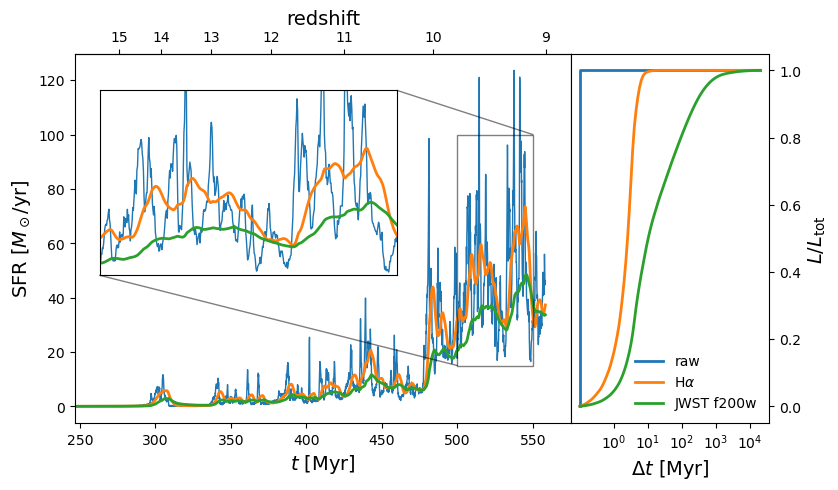

In [40]:
fig, ax1 = plt.subplots(ncols=1)

# define aexp ticks
aexp_min = 0.058
aexp_max = 0.102
tick_aexp = np.arange(0.06, 0.1 + 0.01, 0.01)

z_min = 15.2
z_max = 8.9
tick_z = [15, 14, 13, 12, 11, 10, 9]

aexp_list = np.linspace(1e-3, 1., 2**10)
time_list = np.array([aexp_to_proper_time(aexp_list[i]) for i in range(len(aexp_list))])
proper_time_to_z_interp = interp1d(time_list/const.Myr, 1/aexp_list-1, fill_value='extrapolate')
z_to_proper_time_interp = interp1d(1/aexp_list-1, time_list/const.Myr, fill_value='extrapolate')

# create axes
axtop = ax1.secondary_xaxis('top', functions=(proper_time_to_z_interp, z_to_proper_time_interp))
ax2 = ax1.inset_axes([0.05, 0.4, 0.6, 0.5], xlim=(500, 550), ylim=(15, 100), xticks=[], yticks=[])
ax3 = ax1.inset_axes([1, 0, 0.4, 1])

# plot raw SFR
ax1.plot(time/const.Myr, SFR/(const.M_sol/const.yr), label='raw', lw=1)
ax2.plot(time/const.Myr, SFR/(const.M_sol/const.yr), lw=1)

for resp_func_name in ['Halpha', 'f200w']:

    # plot convolved SFR
    SFR_conv = getattr(data, 'SFR_%s' % resp_func_name)
    ax1.plot(time/const.Myr, SFR_conv/(const.M_sol/const.yr), lw=2)
    ax2.plot(time/const.Myr, SFR_conv/(const.M_sol/const.yr), lw=2)

# plot cumulative response functions
ax3.plot(np.array([data_resp_func.time[0], data_resp_func.time[0], data_resp_func.time[-1]])/const.Myr, [0, 1, 1], lw=2, color='C0', label='raw')
ax3.plot(data_resp_func.time/const.Myr, Halpha_cum, lw=2, color='C1', label=r'H$\alpha$')
ax3.plot(data_resp_func.time/const.Myr, f200w_cum, lw=2, color='C2', label='JWST f200w')
    
# set up inset axis
ax1.indicate_inset_zoom(ax2, edgecolor="black")
    
# set up primary axis
ax1.set_ylabel(r"SFR [$M_\odot / {\rm yr}$]", fontsize=14)
ax1.set_xlabel(r"$t$ [Myr]", fontsize=14)
ax1.set_xlim(aexp_to_proper_time(aexp_min) / const.Myr, aexp_to_proper_time(aexp_max) / const.Myr)
ax3.legend(loc=4, frameon=False)
axtop.set_xticks(tick_z)
axtop.set_xlabel(r'redshift', fontsize=14)

# set up secondary axis
ax3.yaxis.tick_right()
ax3.yaxis.set_label_position('right')
ax3.set_xscale('log')
ax3.set_xlabel(r'$\Delta t$ [${\rm Myr}$]', fontsize=14)
ax3.set_ylabel(r'$L/L_{\rm tot}$', fontsize=14)
ax3.set_xticks([1e0, 1e1, 1e2, 1e3, 1e4]);

save_fig('SFR_conv')


In [3]:
sim_list  = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0"), (12, "nophot"), (12, "nofeed")]
npz_list  = ["data_d47_l1_b5.npz", "data_d52_l1_b5.npz", "data_d45_l1_b5.npz", "data_d53_l1_b5.npz", "data_d18_l1_b5.npz"]

num = 512
hist_list = np.empty((5, 5), dtype=object)
bin1_list = np.empty((5, 5), dtype=object)
bin2_list = np.empty((5, 5), dtype=object)

for i in range(5):
    
    sim_round, sim_name = sim_list[i]
    sim = Sim(sim_round, sim_name, npz_list[i])
    sim_dir = move_to_sim_dir(sim_round, sim_name, do_print=False)
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    
    idx_star = np.zeros_like(sim.coord_star, dtype=int)
    for j in [X, Y, Z]: idx_star[j] = np.searchsorted(sim.coord1d[j], sim.coord_star[j])
    idx_star[idx_star==sim.N] = sim.N-1
    nH_star, temp_star = sim.n_H[tuple(idx_star)], sim.temp[tuple(idx_star)]
    
    bin1_list[i, 0], bin2_list[i, 0], hist_list[i, 0] = calc_hist2d(sim.n_H, sim.temp, 1e-3, 3e4, 3e1, 7e8, weight=sim.density*sim.dV, nbin=num)
    bin1_list[i, 1], bin2_list[i, 1], hist_list[i, 1] = calc_hist2d(sim.n_H, sim.temp, 1e-3, 3e4, 3e1, 7e8, weight=sim.density*sim.dV*sim.metallicity, nbin=num)
    bin1_list[i, 2], bin2_list[i, 2], hist_list[i, 2] = data.nH2d, data.temp2d, data.nH_temp_hist2d
    bin1_list[i, 3], bin2_list[i, 3], hist_list[i, 3] = data.nH2d_death, data.temp2d_death, data.nH_temp_hist2d_death
    bin1_list[i, 4], bin2_list[i, 4], hist_list[i, 4] = calc_hist2d(nH_star, temp_star, 1e-3, 3e4, 3e1, 7e8, weight=sim.mass_star, nbin=num)
    
np.savez('/home/za9132/analysis/phaseall', hist_list=hist_list, bin1_list=bin1_list, bin2_list=bin2_list)


Moving to directory '/home/za9132/scratch/romain/round9/mstar0p2'.
Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.
Moving to directory '/home/za9132/scratch/romain/round9/mstar5p0'.
Moving to directory '/home/za9132/scratch/romain/round12/nophot'.
Moving to directory '/home/za9132/scratch/romain/round12/nofeed'.


In [65]:
data = np.load('phaseall.npz', allow_pickle=True)
hist_list = data['hist_list']
bin1_list = data['bin1_list']
bin2_list = data['bin2_list']
dx = 4.186058239176291e+19


/tmp/ipykernel_2336742/1701727203.py:24: RuntimeWarning: divide by zero encountered in log10
  im = ax.pcolormesh(bin1_list[i, 0], bin2_list[i, 0], np.log10(hist_list[i, 0]/const.M_sol).T, vmin=5.5, vmax=9.5, cmap=custom_cmp)


Saved figure as 'phaseall-090520241450.png'


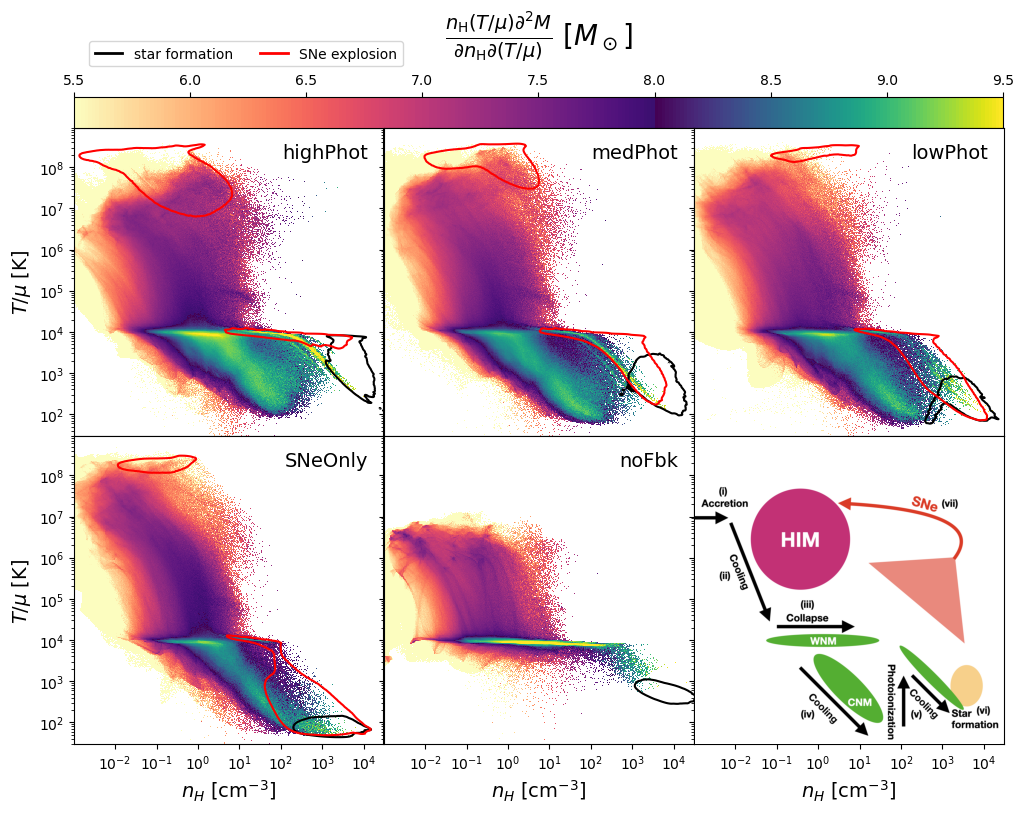

In [68]:
bottom, top = plt.colormaps['magma_r'], plt.colormaps['viridis']
custom_colors = np.vstack((bottom(np.linspace(0, 0.8, 10*16)), top(np.linspace(0, 1, 6*16))))
custom_cmp = ListedColormap(custom_colors, name='custom')

label_list = ['highPhot', 'medPhot', 'lowPhot', 'SNeOnly', 'noFbk']
sne_list = [True, True, True, True, False]

frac = 0.75
sigma_list = [2, 1, 0, 3]
color_list = ['orange', 'black', 'red', 'orange']

E_SNe = 1e51
m_SNe = 10*const.M_sol

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 8), sharex=True, sharey=True)
plt.subplots_adjust(wspace=1e-3, hspace=1e-3)

for i in range(5):
    
    ax = axs.flatten()[i]
    ax.set_xscale('log')
    ax.set_yscale('log')

    im = ax.pcolormesh(bin1_list[i, 0], bin2_list[i, 0], np.log10(hist_list[i, 0]/const.M_sol).T, vmin=5.5, vmax=9.5, cmap=custom_cmp)

    for j in [1, 2]:
    
        hist_sm = gaussian_filter(hist_list[i, j+1], sigma_list[j])
        field = hist_sm.flatten()
        idx_sorted = np.argsort(field)
        cumsum = np.cumsum(field[idx_sorted])
        level = field[idx_sorted[np.searchsorted(cumsum, (1-frac)*cumsum[-1])]]/const.M_sol
        ax.contour(bin1_list[i, j+1], bin2_list[i, j+1], hist_sm.T/const.M_sol, levels=[level], colors=color_list[j])

    if sne_list[i]:
        rho1d = bin1_list[i, 0]*const.m_p/const.X_cosmo+m_SNe/dx**3
        temp_SNe = const.m_p/const.k_B * (E_SNe/dx**3)/rho1d
        nH_crit = 100*(dx/(3*const.pc))**(0.42)
        
    ax.annotate(label_list[i], xy=(0.95, 0.95), xycoords='axes fraction', horizontalalignment='right', verticalalignment='top', fontsize=14)
        
axs[0, 0].set_xlim(1e-3, 3e4)
axs[0, 0].set_ylim(3e1, 9e8)
axs[0, 0].set_xticks([1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4])
for i in range(3): axs[1, i].set_xlabel(r'$n_H$ [${\rm cm^{-3}}$]', fontsize=14)
for j in range(2): axs[j, 0].set_ylabel(r'$T/\mu$ [${\rm K}$]', fontsize=14)
    
ax_schem = axs[1, 2].inset_axes([0, 0, 0.99, 0.99])
schem = plt.imread('/home/za9132/analysis/figures/schematic.png')
ax_schem.imshow(schem)
ax_schem.axis('off')
    
cax = axs[0, 0].inset_axes([0, 1, 3, 0.1])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label(r'$\frac{n_{\rm H} (T/\mu) \partial^2 M}{\partial n_{\rm H} \partial (T/\mu)}$ [$M_\odot$]', fontsize=20, labelpad=20)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")

cust_lines = [Line2D([0], [0], color=color, lw=2, linestyle='-') for color in ['black', 'red']]
axs[0, 0].legend(cust_lines, [r'star formation', r'SNe explosion'], ncol=3, fontsize=10, loc=[0.05, 1.2])
    
save_fig('phaseall')
    

In [70]:
vmin = 1e-27
vmax = 1e-10
nbin = 64

density1d1, hist1 = calc_hist1d(sim.density, vmin, vmax, weight=(sim.density*sim.dV), nbin=8*nbin, do_log=True)
denisty1d2, hist2 = calc_hist_density_mff(vmin, vmax, nbin, sim.density.flatten(), sim.mach_turb.flatten(), sim.alpha_vir.flatten(), weight=(sim.density*sim.dV).flatten(), do_trunc=False)
denisty1d2, hist3 = calc_hist_density_mff(vmin, vmax, nbin, sim.density.flatten(), sim.mach_turb.flatten(), sim.alpha_vir.flatten(), weight=(sim.density*sim.dV).flatten(), do_trunc=True)

np.savez('/home/za9132/analysis/densitypdf_mff', density1d1=density1d1, density1d2=density1d2, hist1=hist1, hist2=hist2, hist3=hist3)


In [149]:
data = np.load('/home/za9132/analysis/densitypdf_mff.npz')
density1d1 = data['density1d1']
density1d2 = data['density1d2']
hist1 = data['hist1']
hist2 = data['hist2']
hist3 = data['hist3']


Saved figure as 'rho_mff-041120241614.png'


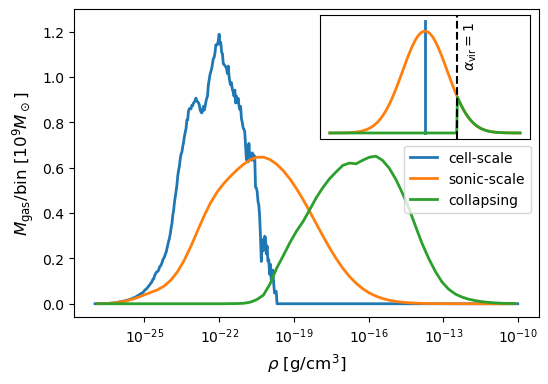

In [150]:
fig, ax = plt.subplots(figsize=(6, 4))

unit = 1e9*const.M_sol
ax.plot(density1d1, hist1/unit, lw=2, label='cell-scale')
ax.plot(density1d2, hist2/unit/2, lw=2, label='sonic-scale')
ax.plot(density1d2, hist3/unit/2, lw=2, label='collapsing')
ax.set_ylim(None, 1.3)

s = np.linspace(-3, 3, 256)
axin = ax.inset_axes([0.53, 0.58, 0.45, 0.4], xticks=[], yticks=[])
axin.plot([0, 0], [0, 1.1], lw=2, color='C0')
axin.plot(s, np.exp(-s**2), lw=2, color='C1')
axin.plot(s, np.exp(-s**2)*(s>1), lw=2, color='C2')
axin.axvline(x=1, linestyle='--', color='black')
axin.annotate(r'$\alpha_{\rm vir} = 1$', (1.2, 0.66), rotation=90)
    
ax.set_xscale('log')
ax.set_xlabel(r'$\rho$ [${\rm g/cm^{3}}$]', fontsize=12)
ax.set_ylabel(r'$M_{\rm gas}/{\rm bin}$ [$10^9 M_\odot$]', fontsize=12)
ax.legend(loc=(0.71, 0.34), fontsize=10)

save_fig('rho_mff')


Moving to directory '/home/za9132/scratch/romain/round9/mstar0p2'.
Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.
Moving to directory '/home/za9132/scratch/romain/round9/mstar5p0'.
Moving to directory '/home/za9132/scratch/romain/round12/nophot'.
Saved figure as 'star-102620242221.png'


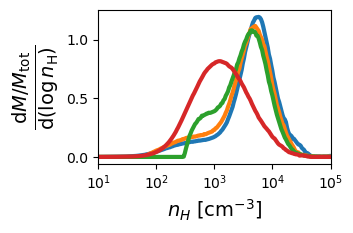

In [27]:
fig, ax = plt.subplots(figsize=(3, 2))
sim_list = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0"), (12, "nophot")]

for sim_round, sim_name in sim_list:

    move_to_sim_dir(sim_round, sim_name)
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    plt.plot(data.nH1d, data.nH_pdf1d, lw=3)

plt.xscale('log')
plt.xlabel(r'$n_H$ [${\rm cm^{-3}}$]', fontsize=14)
plt.ylabel(r'$\frac{{\rm d} M/M_{\rm tot}}{{\rm d}(\log n_{\rm H})}$', fontsize=20)

plt.xlim(1e1, 1e5)
plt.xticks([1e1, 1e2, 1e3, 1e4, 1e5])

save_fig("star")


Moving to directory '/home/za9132/scratch/romain/round9/bturbfunc'.
Saved figure as 'mstarhist-090520241632.png'


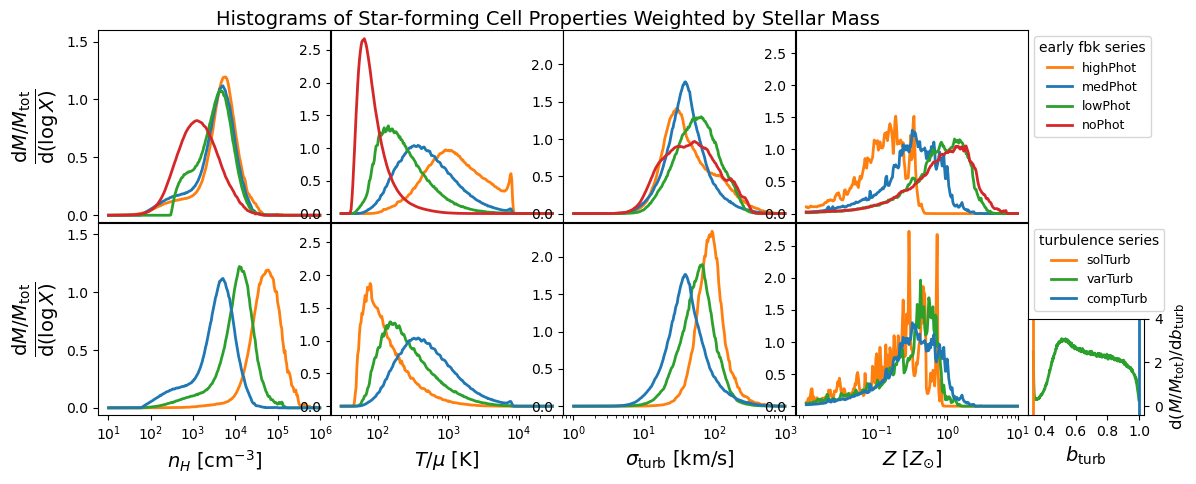

In [78]:
fig, axs = plt.subplots(figsize=(12, 5), nrows=2, ncols=4, sharex='col', sharey='col')
plt.subplots_adjust(wspace=1e-3, hspace=1e-3)

sim_list_list = [[(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0"), (12, "nophot"), (11, "mstar0p2"), (11, "mstar1p0"), (11, "mstar5p0")], [(9, "bturb0p3"), (9, "bturbfunc"), (9, "fiducial")]]
label_list_list = [[r"highPhot", r"medPhot", r"lowPhot", "noPhot"], [r"solTurb", r"varTurb", r"compTurb"]]
color_list_list = [["C1", "C0", "C2", "C3"], ["C1", "C2", "C0"]]
linestyle_list_list = [["-"]*4, ["-"]*3]

for i in range(2):
    
    sim_list, label_list, color_list, linestyle_list = sim_list_list[i], label_list_list[i], color_list_list[i], linestyle_list_list[i]
    
    for j in range(4):
        
        ax = axs[i, j]
        ax.set_xscale('log')
        if j==0: ax.set_ylabel(r'$\frac{{\rm d} M/M_{\rm tot}}{{\rm d}(\log X)}$', fontsize=20)
        #ax.set_yticks([0, 1]) #if j==0 else ax.set_yticks([])
        
    for j in range(len(label_list)):
    
        sim_round, sim_name = sim_list[j]
        move_to_sim_dir(sim_round, sim_name, do_print=False)
        sim_latex = sim_name_to_latex[sim_name]
        data = SimpleNamespace(**np.load('starcat/data.npz'))

        axs[i, 0].plot(data.nH1d, data.nH_pdf1d, color=color_list[j], linestyle=linestyle_list[j], lw=2)
        axs[i, 1].plot(data.temp1d, data.temp_pdf1d, color=color_list[j], linestyle=linestyle_list[j], lw=2)
        axs[i, 2].plot(data.sig_turb1d/const.km, data.sig_turb_pdf1d, color=color_list[j], linestyle=linestyle_list[j], lw=2)
        axs[i, 3].plot(data.metallicity1d/const.Z_sol, data.metallicity_pdf1d, color=color_list[j], linestyle=linestyle_list[j], lw=2)

axs[1, 0].set_xlabel(r'$n_H$ [${\rm cm^{-3}}$]', fontsize=14)
axs[1, 1].set_xlabel(r'$T/\mu$ [${\rm K}$]', fontsize=14)
axs[1, 2].set_xlabel(r'$\sigma_{\rm turb}$ [${\rm km/s}$]', fontsize=14)
axs[1, 3].set_xlabel(r'$Z$ [$Z_{\odot}$]', fontsize=14)
        
axs[0, 0].set_ylim(None, 1.6);
axs[1, 0].set_xticks([1e1, 1e2, 1e3, 1e4, 1e5, 1e6]);
axs[1, 3].set_xticks([1e-1, 1e0, 1e1]);

cust_lines = [Line2D([0], [0], color=color, lw=2) for color in color_list_list[0]][:4]
axs[0, 3].legend(cust_lines, label_list_list[0], fontsize=9, loc=2, bbox_to_anchor=(1, 1), title='early fbk series')
cust_lines = [Line2D([0], [0], color=color, lw=2) for color in color_list_list[1]][:4]
axs[1, 3].legend(cust_lines, label_list_list[1], fontsize=9, loc=2, bbox_to_anchor=(1, 1), title='turbulence series')

sim_dir = move_to_sim_dir(9, "bturbfunc")
data = SimpleNamespace(**np.load('starcat/data.npz'))
axin = axs[1, 3].inset_axes([1., 0., 0.5, 0.5], xticks=[0.4, 0.6, 0.8, 1.0])
axin.plot(data.b_turb1d, data.b_turb_hist1d/1e10/const.M_sol, lw=2, color='C2')
axin.axvline(x=1., color='C0', lw=2)
axin.axvline(x=1/3, color='C1', lw=2)
axin.set_xlabel(r"$b_{\rm turb}$", fontsize=14)
axin.yaxis.tick_right()
axin.yaxis.set_label_position('right')
axin.set_ylabel(r'${\rm d}(M/M_{\rm tot})/{\rm d}b_{\rm turb}$', fontsize=12)
axin.set_ylim(-0.4, 4)

plt.suptitle('Histograms of Star-forming Cell Properties Weighted by Stellar Mass', fontsize=14, y=0.92)

#save_fig('mstarhist')
        

Moving to directory '/home/za9132/scratch/romain/round9/bturbfunc'.
Saved figure as 'nsnehist-090520241634.png'


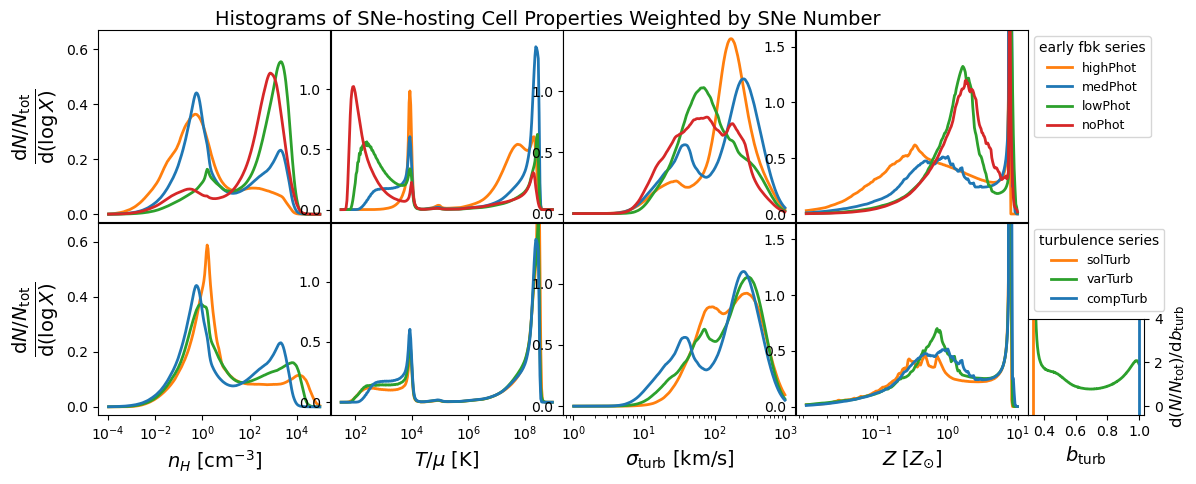

In [81]:
fig, axs = plt.subplots(figsize=(12, 5), nrows=2, ncols=4, sharex='col', sharey='col')
plt.subplots_adjust(wspace=1e-3, hspace=1e-3)

sim_list_list = [[(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0"), (12, "nophot"), (11, "mstar0p2"), (11, "mstar1p0"), (11, "mstar5p0")], [(9, "bturb0p3"), (9, "bturbfunc"), (9, "fiducial")]]
label_list_list = [[r"highPhot", r"medPhot", r"lowPhot", "noPhot"], [r"solTurb", r"varTurb", r"compTurb"]]
color_list_list = [["C1", "C0", "C2", "C3"], ["C1", "C2", "C0"]]
linestyle_list_list = [["-"]*4, ["-"]*3]

for i in range(2):
    
    sim_list, label_list, color_list, linestyle_list = sim_list_list[i], label_list_list[i], color_list_list[i], linestyle_list_list[i]
    
    for j in range(4):
        
        ax = axs[i, j]
        ax.set_xscale('log')
        if j==0: ax.set_ylabel(r'$\frac{{\rm d} N/N_{\rm tot}}{{\rm d}(\log X)}$', fontsize=20)
        #ax.set_yticks([0]) if j==0 else ax.set_yticks([])
        
    for j in range(len(label_list)):
    
        sim_round, sim_name = sim_list[j]
        move_to_sim_dir(sim_round, sim_name, do_print=False)
        sim_latex = sim_name_to_latex[sim_name]
        data = SimpleNamespace(**np.load('starcat/data.npz'))

        axs[i, 0].plot(data.nH1d_death, data.nH_pdf1d_death, color=color_list[j], linestyle=linestyle_list[j], lw=2)
        axs[i, 1].plot(data.temp1d_death, data.temp_pdf1d_death, color=color_list[j], linestyle=linestyle_list[j], lw=2)
        axs[i, 2].plot(data.sig_turb1d_death/const.km, data.sig_turb_pdf1d_death, color=color_list[j], linestyle=linestyle_list[j], lw=2)
        axs[i, 3].plot(data.metallicity1d_death/const.Z_sol, data.metallicity_pdf1d_death, color=color_list[j], linestyle=linestyle_list[j], lw=2)

axs[1, 0].set_xlabel(r'$n_H$ [${\rm cm^{-3}}$]', fontsize=14)
axs[1, 1].set_xlabel(r'$T/\mu$ [${\rm K}$]', fontsize=14)
axs[1, 2].set_xlabel(r'$\sigma_{\rm turb}$ [${\rm km/s}$]', fontsize=14)
axs[1, 3].set_xlabel(r'$Z$ [$Z_{\odot}$]', fontsize=14)
        
axs[0, 0].set_ylim(None, 0.67);
axs[0, 1].set_ylim(None, 1.49);
axs[0, 3].set_ylim(-0.075, 1.65);
axs[1, 0].set_xticks([1e-4, 1e-2, 1e0, 1e2, 1e4]);
axs[1, 1].set_xticks([1e2, 1e4, 1e6, 1e8]);
axs[1, 3].set_xticks([1e-1, 1e0, 1e1]);

cust_lines = [Line2D([0], [0], color=color, lw=2) for color in color_list_list[0]][:4]
axs[0, 3].legend(cust_lines, label_list_list[0], fontsize=9, loc=2, bbox_to_anchor=(1, 1), title='early fbk series')
cust_lines = [Line2D([0], [0], color=color, lw=2) for color in color_list_list[1]][:4]
axs[1, 3].legend(cust_lines, label_list_list[1], fontsize=9, loc=2, bbox_to_anchor=(1, 1), title='turbulence series')

sim_dir = move_to_sim_dir(9, "bturbfunc")
data = SimpleNamespace(**np.load('starcat/data.npz'))
axin = axs[1, 3].inset_axes([1., 0., 0.5, 0.5], xticks=[0.4, 0.6, 0.8, 1.0])
axin.plot(data.b_turb1d_death, data.b_turb_pdf1d_death, lw=2, color='C2')
axin.axvline(x=1., color='C0', lw=2)
axin.axvline(x=1/3, color='C1', lw=2)
axin.set_xlabel(r"$b_{\rm turb}$", fontsize=14)
axin.yaxis.tick_right()
axin.yaxis.set_label_position('right')
axin.set_ylabel(r'${\rm d}(N/N_{\rm tot})/{\rm d}b_{\rm turb}$', fontsize=12)
axin.set_ylim(-0.4, 4)

plt.suptitle('Histograms of SNe-hosting Cell Properties Weighted by SNe Number', fontsize=14, y=0.92)

save_fig('nsnehist')


In [55]:
sim_list_list = [[(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0"), (12, "nophot")], [(9, "instantfeedback"), (9, "fastfeedback"), (9, "fiducial")], [(9, "bturb0p3"), (9, "bturbfunc"), (9, "fiducial")]]
npz_list_list = [["data_d47_l1_b5.npz", "data_d52_l1_b5.npz", "data_d45_l1_b5.npz", "data_d53_l1_b5.npz"], ["data_d48_l1_b5.npz", "data_d52_l1_b5.npz", "data_d52_l1_b5.npz"], ["data_d45_l1_b5.npz", "data_d47_l1_b5.npz", "data_d52_l1_b5.npz"]]
bound_list = [(1e-2, 1e4), (3e1, 3e4), (1e0*const.km, 1e3*const.km), (1e-2*const.Z_sol, 1e1*const.Z_sol), (1/3, 1.0)]
do_log_list = [True, True, True, True, False]

nvar = 5
num = 64

bin_list = [[np.zeros((nvar, num)), np.zeros((nvar, num)), np.zeros((nvar, num)), np.zeros((nvar, num)), np.zeros((nvar, num)), np.zeros((nvar, num)), np.zeros((nvar, num))], [np.zeros((nvar, num)), np.zeros((nvar, num)), np.zeros((nvar, num))], [np.zeros((nvar, num)), np.zeros((nvar, num)), np.zeros((nvar, num))]]
hist_list = [[np.zeros((nvar, num)), np.zeros((nvar, num)), np.zeros((nvar, num)), np.zeros((nvar, num)), np.zeros((nvar, num)), np.zeros((nvar, num)), np.zeros((nvar, num))], [np.zeros((nvar, num)), np.zeros((nvar, num)), np.zeros((nvar, num))], [np.zeros((nvar, num)), np.zeros((nvar, num)), np.zeros((nvar, num))]]

for i in range(3):
    
    sim_list, npz_list = sim_list_list[i], npz_list_list[i]
    nsim = len(sim_list)
    
    for j in range(nsim):
        
        sim_round, sim_name = sim_list[j]
        sim = Sim(sim_round, sim_name, npz_list[j])
        var_list = [sim.n_H, sim.temp, sim.vel_turb, sim.metallicity, sim.b_turb]
        for k in range(nvar):
            bin_list[i][j][k], hist_list[i][j][k] = calc_hist1d(var_list[k], bound_list[k][0], bound_list[k][1], weight=(sim.density*sim.dV/const.M_sol), nbin=num, do_pdf=True)

np.savez('/home/za9132/analysis/gas_pdf1d', bin_list=bin_list, hist_list=hist_list)


Moving to directory '/home/za9132/scratch/romain/round9/mstar0p2'.
Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.
Moving to directory '/home/za9132/scratch/romain/round9/mstar5p0'.
Moving to directory '/home/za9132/scratch/romain/round12/nophot'.
Moving to directory '/home/za9132/scratch/romain/round9/instantfeedback'.
Moving to directory '/home/za9132/scratch/romain/round9/fastfeedback'.
Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.
Moving to directory '/home/za9132/scratch/romain/round9/bturb0p3'.
Moving to directory '/home/za9132/scratch/romain/round9/bturbfunc'.
Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.


In [82]:
data = np.load('/home/za9132/analysis/gas_pdf1d.npz', allow_pickle=True)
bin_list = data['bin_list']
hist_list = data['hist_list']


Moving to directory '/home/za9132/scratch/romain/round9/bturbfunc'.
Saved figure as 'mgashist-090520241648.png'


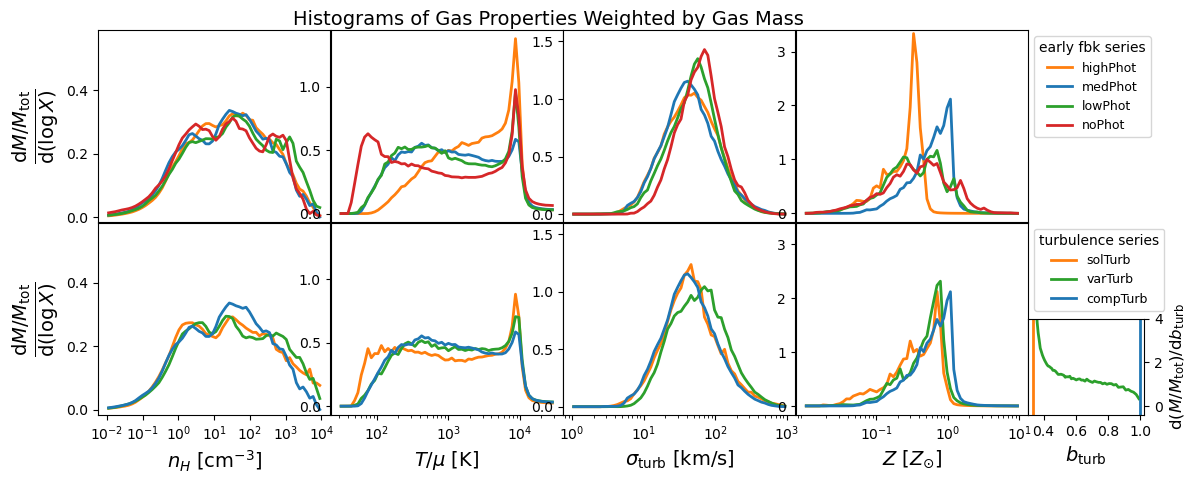

In [90]:
fig, axs = plt.subplots(figsize=(12, 5), nrows=2, ncols=4, sharex='col', sharey='col')
plt.subplots_adjust(wspace=1e-3, hspace=1e-3)

sim_list_list = [[(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0"), (12, "nophot"), (11, "mstar0p2"), (11, "mstar1p0"), (11, "mstar5p0")], [(9, "bturb0p3"), (9, "bturbfunc"), (9, "fiducial")]]
label_list_list = [[r"highPhot", r"medPhot", r"lowPhot", "noPhot"], [r"solTurb", r"varTurb", r"compTurb"]]
color_list_list = [["C1", "C0", "C2", "C3"], ["C1", "C2", "C0"]]
linestyle_list_list = [["-"]*4, ["-"]*3]
unit_list = [1, 1, const.km, const.Z_sol]

for i, idx in enumerate([0, 2]):
    
    sim_list, label_list, color_list, linestyle_list = sim_list_list[i], label_list_list[i], color_list_list[i], linestyle_list_list[i]
    
    for j in range(4):
        
        ax = axs[i, j]
        ax.set_xscale('log')
        if j==0: ax.set_ylabel(r'$\frac{{\rm d} M/M_{\rm tot}}{{\rm d}(\log X)}$', fontsize=20)
        #ax.set_yticks([0]) if j==0 else ax.set_yticks([])
        
    for j in range(len(label_list)):
        
        for k in range(4):
            
            axs[i, k].plot(bin_list[idx][j][k]/unit_list[k], hist_list[idx][j][k], color=color_list[j], linestyle=linestyle_list[j], lw=2)

axs[1, 0].set_xlabel(r'$n_H$ [${\rm cm^{-3}}$]', fontsize=14)
axs[1, 1].set_xlabel(r'$T/\mu$ [${\rm K}$]', fontsize=14)
axs[1, 2].set_xlabel(r'$\sigma_{\rm turb}$ [${\rm km/s}$]', fontsize=14)
axs[1, 3].set_xlabel(r'$Z$ [$Z_{\odot}$]', fontsize=14)
        
axs[0, 0].set_ylim(None, 0.59);
axs[0, 3].set_ylim(None, 3.4);
axs[1, 0].set_xticks([1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4]);
axs[1, 3].set_xticks([1e-1, 1e0, 1e1]);
axs[0, 2].set_ylim(None, 1.6)

cust_lines = [Line2D([0], [0], color=color, lw=2) for color in color_list_list[0]][:4]
axs[0, 3].legend(cust_lines, label_list_list[0], fontsize=9, loc=2, bbox_to_anchor=(1, 1), title='early fbk series')
cust_lines = [Line2D([0], [0], color=color, lw=2) for color in color_list_list[1]][:4]
axs[1, 3].legend(cust_lines, label_list_list[1], fontsize=9, loc=2, bbox_to_anchor=(1, 1), title='turbulence series')

sim_dir = move_to_sim_dir(9, "bturbfunc")
data = SimpleNamespace(**np.load('starcat/data.npz'))
axin = axs[1, 3].inset_axes([1., 0., 0.5, 0.5], xticks=[0.4, 0.6, 0.8, 1.0])
axin.plot(bin_list[1][1][4], hist_list[1][1][4], lw=2, color='C2')
axin.axvline(x=1., color='C0', lw=2)
axin.axvline(x=1/3, color='C1', lw=2)
axin.set_xlabel(r"$b_{\rm turb}$", fontsize=14)
axin.yaxis.tick_right()
axin.yaxis.set_label_position('right')
axin.set_ylabel(r'${\rm d}(M/M_{\rm tot})/{\rm d}b_{\rm turb}$', fontsize=12)
axin.set_ylim(-0.4, 4)

plt.suptitle('Histograms of Gas Properties Weighted by Gas Mass', fontsize=14, y=0.92)

save_fig('mgashist')


In [ ]:
fig, axs = plt.subplots(figsize=(12, 5), nrows=2, ncols=4, sharex='col', sharey='col')
plt.subplots_adjust(wspace=1e-3, hspace=1e-3)

sim_list_list = [[(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0"), (12, "nophot")], [(9, "bturb0p3"), (9, "bturbfunc"), (9, "fiducial")]]
label_list_list = [[r"high phot", r"med phot$^*$", r"low phot", "no phot"], [r"sol turb", r"var turb", r"comp turb$^*$"]]
color_list_list = [["C1", "C0", "C2", "C3"], ["C1", "C2", "C0"]]
linestyle_list_list = [["-"]*4, ["-"]*3]
unit_list = [1, 1, const.km, const.Z_sol]

for i in range(2):
    
    sim_list, label_list, color_list, linestyle_list = sim_list_list[i], label_list_list[i], color_list_list[i], linestyle_list_list[i]
    
    for j in range(4):
        
        ax = axs[i, j]
        ax.set_xscale('log')
        if j==0: ax.set_ylabel(r'$\frac{{\rm d} V/V_{\rm tot}}{{\rm d}(\log X)}$', fontsize=20)
        #ax.set_yticks([0]) if j==0 else ax.set_yticks([])
        
    for j in range(len(label_list)):
        
        for k in range(4):
            
            axs[i, k].plot(bin_list[i][j][k]/unit_list[k], hist_list[i][j][k], color=color_list[j], linestyle=linestyle_list[j], lw=2)

axs[1, 0].set_xlabel(r'$n_H$ [${\rm cm^{-3}}$]', fontsize=14)
axs[1, 1].set_xlabel(r'$T/\mu$ [${\rm K}$]', fontsize=14)
axs[1, 2].set_xlabel(r'$\sigma_{\rm turb}$ [${\rm km/s}$]', fontsize=14)
axs[1, 3].set_xlabel(r'$Z$ [$Z_{\odot}$]', fontsize=14)
        
axs[0, 0].set_ylim(None, 0.69);
axs[0, 3].set_ylim(None, 3.4);
axs[1, 0].set_xticks([1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1]);
axs[1, 1].set_xticks([1e3, 1e4, 1e5, 1e6, 1e7, 1e8]);
axs[1, 2].set_xticks([1e0, 1e1, 1e2, 1e3]);
axs[1, 3].set_xticks([1e-1, 1e0, 1e1]);

axs[0, 0].annotate('Early fbk series', (-0.46, 0.5), xycoords='axes fraction', fontsize=12, rotation=90, verticalalignment='center')
axs[1, 0].annotate('Turbulence series', (-0.46, 0.5), xycoords='axes fraction', fontsize=12, rotation=90, verticalalignment='center')

for i in range(3):
    cust_lines = [Line2D([0], [0], color=color, lw=2) for color in color_list_list[i]][:4]
    axs[i, 3].legend(cust_lines, label_list_list[i], fontsize=10, loc=2, bbox_to_anchor=(1, 1))
cust_lines = [Line2D([0], [0], color='black', lw=2, linestyle='-'), Line2D([0], [0], color='black', lw=2, linestyle='--')]
axs[0, 2].legend(cust_lines, ['multi-freefall', 'constant SFE'], fontsize=10, loc=2, bbox_to_anchor=(2, 0.47))

sim_dir = move_to_sim_dir(9, "bturbfunc")
data = SimpleNamespace(**np.load('starcat/data.npz'))
axin = axs[2, 3].inset_axes([1., 0., 0.55, 0.55], xticks=[0.4, 0.6, 0.8, 1.0])
axin.plot(bin_list[1][1][4], hist_list[1][1][4], lw=2, color='C2')
axin.axvline(x=1., color='C0', lw=2)
axin.axvline(x=1/3, color='C1', lw=2)
axin.set_xlabel(r"$b_{\rm turb}$", fontsize=14)
axin.yaxis.tick_right()
axin.yaxis.set_label_position('right')
axin.set_ylabel(r'${\rm d}(V/V_{\rm tot})/{\rm d}b_{\rm turb}$', fontsize=12)
axin.set_ylim(-0.4, 4)

plt.suptitle('Histograms of Gas Properties Weighted by Volume', fontsize=14, y=0.92)

#save_fig('mgasvolhist')


In [29]:
sim_list = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0"), (12, "nophot"), (11, "mstar0p2"), (11, "mstar1p0"), (11, "mstar5p0"), (9, "bturb0p3"), (9, "bturbfunc"), (9, "fiducial"), (12, "nofeed"), (12, "noboth"), (9, 'fastfeedback')]

for i in range(len(sim_list)):
    sim_round, sim_name = sim_list[i]
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    data.SFR = data.starmass_hist1d
    
    cond = data.time1d>aexp_to_proper_time(0.1)-50*const.Myr
    #print('%.4g'%(np.mean(data.SFR[cond])/(const.M_sol/const.yr)))
    #print('%.3g'%(100*median_weighted(data.eps_sf1d, data.eps_sf_hist1d)))
    
    try:
        frac = np.sum((data.rcool1d_death > 10*const.pc) * data.rcool_pdf1d_death) / np.sum(data.rcool_pdf1d_death)
        print(sim_name, frac)
    except:
        pass


mstar0p2 0.7632467082805283
fiducial 0.5963383758399051
mstar5p0 0.19696772352567174
nophot 0.19903196120914948
mstar0p2 0.8341384274406729
mstar1p0 0.5178134299196949
mstar5p0 0.1254036181160631
bturb0p3 0.6046798832701283
bturbfunc 0.5626269433718653
fiducial 0.5963383758399051
fastfeedback 0.5346295559201203


In [3]:
sim = Sim(9, "fiducial", "data_d46_l16_b80.npz")


In [5]:
r_gas = np.sqrt(np.sum(sim.coord**2, axis=0))
r_dm = np.sqrt(np.sum(sim.coord_dm**2, axis=0))

delta = 200
r1d, mass_dm1d = calc_hist1d(r_dm, vmin=0, vmax=(40*const.kpc), weight=sim.mass_dm, do_binnorm=False, do_log=False, nbin=128)
r1d, mass_gas1d = calc_hist1d(r_gas, vmin=0, vmax=(40*const.kpc), weight=(sim.density * sim.dV), do_binnorm=False, do_log=False, nbin=128)
mass_cum1d = np.cumsum(mass_dm1d) + np.cumsum(mass_gas1d)
vol1d = (4/3) * np.pi * r1d**3
rho1d = mass_cum1d / vol1d
Mvir = mass_cum1d[np.argmin(np.abs(rho1d - delta * sim.rho_crit))]


1.5496818793419247e+44

In [10]:
redshift_list = []
time_list = []
Mstar_list = []
Mgas_list = []
Msf_list = []
SFR_list = []
SFR50_list = []
Mdotout_list = []
Mvir_list = []

r_sph = 2 * const.kpc
dr_sph = 0.1 * r_sph
vol_sph = 4/3 * np.pi * ((r_sph + dr_sph)**3 - r_sph**3)
area_sph = 4 * np.pi * r_sph**2

dt = 0.1*const.Myr
eta = 0.2

tstart = 3*const.Myr
tend = 20*const.Myr
tstart_idx = int(tstart/dt)
tend_idx = int(tend/dt)

sigma_idx = int(50*const.Myr/dt)
window = np.zeros(2*sigma_idx-1)
window[sigma_idx:] = 1/sigma_idx

print("aexp,redshift,time,Mvir,Mstar,Mgas,Mgassf,SFR,SFR50,Mdotout")
print("none,none,Myr,Msol,Msol,Msol,Msol,Msol/yr,Msol/yr,Msol/yr")

for dump in range(10, 53):
    
    lowres = 32 if dump < 42 else 16
    sim = Sim(9, "fiducial", f"data_d{dump}_l{lowres}_b80.npz")
    
    r_gas = np.sqrt(np.sum(sim.coord**2, axis=0))
    r_dm = np.sqrt(np.sum(sim.coord_dm**2, axis=0))

    delta = 200
    r1d, mass_dm1d = calc_hist1d(r_dm, vmin=0, vmax=(40*const.kpc), weight=sim.mass_dm, do_binnorm=False, do_log=False, nbin=128)
    r1d, mass_gas1d = calc_hist1d(r_gas, vmin=0, vmax=(40*const.kpc), weight=(sim.density * sim.dV), do_binnorm=False, do_log=False, nbin=128)
    mass_cum1d = np.cumsum(mass_dm1d) + np.cumsum(mass_gas1d)
    vol1d = (4/3) * np.pi * r1d**3
    rho1d = mass_cum1d / vol1d
    Mvir = mass_cum1d[np.argmin(np.abs(rho1d - delta * sim.rho_crit))]
    
    lowres = 2 if dump < 42 else 1
    sim = Sim(9, "fiducial", f"data_d{dump}_l{lowres}_b5.npz")
    sim.b_turb = 1.0
    
    aexp = float(sim.aexp)
    redshift = float(sim.redshift)
    time_now = float(sim.time_now)
    
    r = np.sqrt(np.sum(sim.coord**2, axis=0))
    cond = r < r_sph
    
    r_star = np.sqrt(np.sum(sim.coord_star**2, axis=0))
    cond_star = r_star < r_sph
    
    Mgas = np.sum(sim.density * sim.dV * cond)
    Mstar = np.sum(sim.mass_star * cond_star)
    Msf = np.sum(sim.eps_sf * sim.density * sim.dV * cond)
    
    nbin = int(np.floor(10*time_now/const.Myr))
    time, SFR = calc_hist1d(sim.time_starbirth, vmin=0, vmax=time_now, nbin=nbin, weight=sim.mass_star, do_log=False)
    SFR[::-1][tstart_idx:tend_idx] *= 1/np.linspace(1, 1-eta, tend_idx-tstart_idx)
    SFR[::-1][tend_idx:] *= 1/(1-eta)
    SFR50 = np.convolve(SFR, window, mode='same')

    vr = np.sum(sim.coord * sim.vel_vec, axis=0) / r
    cond_sph = (r > r_sph) * (r < (r_sph + dr_sph))
    cond_flux = vr > 0
    Mdot_out = np.sum(sim.density * vr * sim.dV * cond_sph * cond_flux) * area_sph / vol_sph
    
    redshift_list.append(redshift)
    time_list.append(time_now)
    Mstar_list.append(Mstar)
    Mgas_list.append(Mgas)
    Msf_list.append(Msf)
    SFR_list.append(SFR[-1])
    SFR50_list.append(SFR50[-1])
    Mdotout_list.append(Mdot_out)
    Mvir_list.append(Mvir)
    
    print(f"{aexp:.6g},{redshift:.6g},{(time_now/const.Myr):.6g},{(Mvir/const.M_sol):.6g},{(Mstar/const.M_sol):.6g},{(Mgas/const.M_sol):.6g},{(Msf/const.M_sol):.6g},{(SFR[-1]/(const.M_sol/const.yr)):.6g},{(SFR50[-1]/(const.M_sol/const.yr)):.6g},{(Mdot_out/(const.M_sol/const.yr)):.6g}")

redshift_list = np.array(redshift_list)
time_list = np.array(time_list)
Mstar_list = np.array(Mstar_list)
Mgas_list = np.array(Mgas_list)
Msf_list = np.array(Msf_list)
SFR_list = np.array(SFR_list)
SFR50_list = np.array(SFR50_list)
Mdotout_list = np.array(Mdotout_list)
Mvir_list = np.array(Mvir_list)
    

aexp,redshift,time,Mvir,Mstar,Mgas,Mgassf,SFR,SFR50,Mdotout
none,none,Myr,Msol,Msol,Msol,Msol,Msol/yr,Msol/yr,Msol/yr
0.0633912,14.7751,281.892,2.1447e+09,1.0781e+06,1.58719e+08,1.31253e+07,0.131981,0.0226238,0.989728
0.0644818,14.5082,289.197,2.71222e+09,1.79513e+06,1.85121e+08,6.58445e+06,0.175974,0.0386926,0.828813
0.0655936,14.2454,296.706,3.06376e+09,5.1578e+06,2.25551e+08,1.01961e+06,1.89231,0.105654,0.825253
0.0667012,13.9922,304.251,3.66332e+09,3.63625e+07,2.3551e+08,4.56368e+06,5.5441,0.73715,4.55723
0.0678529,13.7378,312.163,4.45484e+09,5.53178e+07,2.27729e+08,579791,0.307996,1.20509,4.28247
0.0690042,13.4919,320.139,4.8265e+09,5.22862e+07,2.25865e+08,1.00303e+06,0.220014,1.24184,5.59093
0.0700014,13.2854,327.102,5.68107e+09,5.12862e+07,2.45109e+08,1.33757e+07,0.088016,1.25765,10.6496
0.0701551,13.2541,328.18,5.71702e+09,5.14146e+07,2.49956e+08,1.32003e+07,0.0879951,1.25924,8.33222
0.0703689,13.2108,329.68,6.37773e+09,5.16285e+07,2.58422e+08,1.34381e+07,0.131993,1.26157,7.215

Saved figure as 'Mgas_over_Mvir-012320251515.png'


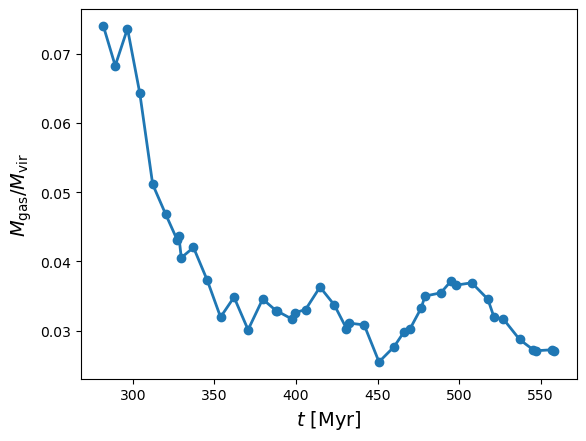

In [16]:
fig, ax = plt.subplots()

#ax.plot(time_list/const.Myr, Mgas_list/const.M_sol/1e9, lw=2, marker="o", label=r"$M_{\rm gas}$")
#ax.plot(time_list/const.Myr, Mstar_list/const.M_sol/1e9, lw=2, marker="o", label=r"$M_{\rm star}$")
#ax.plot(time_list/const.Myr, Msf_list/Mgas_list, lw=2, marker="o")
#ax.plot(time_list/const.Myr, SFR_list/(const.M_sol/const.yr), lw=2, marker="o", label=r"${\rm SFR}$")
#ax.plot(time_list/const.Myr, SFR50_list/(const.M_sol/const.yr), lw=2, marker="o", label=r"${\rm SFR_{\rm 50}}$")
#ax.plot(time_list/const.Myr, Mdotout_list/(const.M_sol/const.yr), lw=2, marker="o", label=r"$\dot{M}_{\rm out}$")
#ax.plot(time_list/const.Myr, Mvir_list/const.M_sol/1e9, lw=2, marker="o")
ax.plot(time_list/const.Myr, Mgas_list/Mvir_list, lw=2, marker="o")

#ax.legend(fontsize=12)
ax.set_xlabel(r"$t$ [${\rm Myr}$]", fontsize=14)
ax.set_ylabel(r"$M_{\rm gas}/M_{\rm vir}$", fontsize=14)
#ax.set_ylim(None, 19)

save_fig("Mgas_over_Mvir")


In [11]:
Mtot = 1e11 * const.M_sol * const.Omega_b0
r_sph = 2 * const.kpc
dr_sph = 0.1 * r_sph
vol_sph = 4/3 * np.pi * ((r_sph + dr_sph)**3 - r_sph**3)
area_sph = 4 * np.pi * r_sph**2

sim_list = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0"), (12, "nophot"), (11, "mstar0p2"), (11, "mstar1p0"), (11, "mstar5p0"), (9, "bturb0p3"), (9, "bturbfunc"), (12, "nofeed"), (12, "nophot"), (12, "noboth"), (9, 'fastfeedback'), (9, "instantfeedback")]
npz_list = ["data_d47_l1_b5.npz", "data_d52_l1_b5.npz", "data_d45_l1_b5.npz", "data_d53_l1_b5.npz", "data_d51_l1_b5.npz", "data_d51_l1_b5.npz", "data_d49_l1_b5.npz", "data_d45_l1_b5.npz", "data_d47_l1_b5.npz", "data_d18_l1_b5.npz", "data_d53_l1_b5.npz", 'data_d18_l1_b5.npz', 'data_d52_l1_b5.npz', 'data_d48_l1_b5.npz']
bturb_list = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0]
is_const_list = [False, False, False, False, True, True, True, False, False, False, False, False, False, False]
name_list = ["highPhot", "fiducial", "lowPhot", "noPhot", "highPhotC", "medPhotC", "lowPhotC", "solTurb", "varTurb", "photOnly", "SNeOnly", "noFbk", "fastSNe", "instSNe"]
num_sim = len(sim_list)

eps_sf_cnst = 0.138
rho_cut_cnst = 4.24e-21

dt = 0.1*const.Myr
nstep = 5583
eta = 0.2

tstart = 3*const.Myr
tend = 20*const.Myr
tstart_idx = int(tstart/dt)
tend_idx = int(tend/dt)

sigma_idx = int(50*const.Myr/dt)
window = np.zeros(2*sigma_idx-1)
window[sigma_idx:] = 1/sigma_idx

print("name,Mstar,Mgas,Mgassf,SFR,SFR50,Mdotout")
print("units,Msol,Msol,Msol,Msol/yr,Msol/yr,Msol/yr")

for i in range(num_sim):
    
    sim_round, sim_name = sim_list[i]
    sim = Sim(sim_round, sim_name, npz_list[i])
    
    r = np.sqrt(np.sum(sim.coord**2, axis=0))
    cond = r < r_sph
    
    r_star = np.sqrt(np.sum(sim.coord_star**2, axis=0))
    cond_star = r_star < r_sph
    
    if bturb_list[i] != 0.0: 
        sim.b_turb = bturb_list[i]
    
    Mgas = np.sum(sim.density * sim.dV * cond)
    Mstar = np.sum(sim.mass_star * cond_star)
    if is_const_list[i]:
        cond_cnst = (sim.density > rho_cut_cnst)
        Msf = eps_sf_cnst * np.sum(sim.density * sim.dV * cond * cond_cnst)
    else:
        Msf = np.sum(sim.eps_sf * sim.density * sim.dV * cond)
    
    time, SFR = calc_hist1d(sim.time_starbirth, vmin=0, vmax=558.3*const.Myr, nbin=5583, weight=sim.mass_star, do_log=False)
    SFR[::-1][tstart_idx:tend_idx] *= 1/np.linspace(1, 1-eta, tend_idx-tstart_idx)
    SFR[::-1][tend_idx:] *= 1/(1-eta)
    SFR50 = np.convolve(SFR, window, mode='same')

    vr = np.sum(sim.coord * sim.vel_vec, axis=0) / r
    cond_sph = (r > r_sph) * (r < (r_sph + dr_sph))
    cond_flux = vr > 0

    Mdot_out = np.sum(sim.density * vr * sim.dV * cond_sph * cond_flux) * area_sph / vol_sph
    
    cond = sim.density_dm > 200 * sim.rho_crit
    Mvir = np.sum(sim.density_dm[cond]) * sim.dV
    
    print(f"{name_list[i]},{(SFR50[-1]/(const.M_sol/const.yr)):.6g}")
    #print(f"{name_list[i]},{(Mstar/const.M_sol):.6g},{(Mgas/const.M_sol):.6g},{(Msf/const.M_sol):.6g},{(SFR[-1]/(const.M_sol/const.yr)):.6g},{(SFR50[-1]/(const.M_sol/const.yr)):.6g},{(Mdot_out/(const.M_sol/const.yr)):.6g}")


name,Mstar,Mgas,Mgassf,SFR,SFR50,Mdotout
units,Msol,Msol,Msol,Msol/yr,Msol/yr,Msol/yr
highPhot,17.2676
fiducial,46.709
lowPhot,55.9984
noPhot,51.501
highPhotC,23.0478
medPhotC,41.7916
lowPhotC,66.512
solTurb,32.9014
varTurb,56.4057
photOnly,82.4507
SNeOnly,51.501
noFbk,83.1826
fastSNe,40.9335
instSNe,43.4073


In [9]:
r_sph = 1 * const.kpc
dr_sph = 0.1 * r_sph
vol_sph = 4/3 * np.pi * ((r_sph + dr_sph)**3 - r_sph**3)
area_sph = 4 * np.pi * r_sph**2

dt = 0.1*const.Myr
nstep = 5583
eta = 0.2

tstart = 3*const.Myr
tend = 20*const.Myr
tstart_idx = int(tstart/dt)
tend_idx = int(tend/dt)

window = np.zeros(2*nstep-1)
window[nstep:nstep+tstart_idx] = 1
window[nstep+tstart_idx:nstep+tend_idx] = np.linspace(1, 1-eta, tend_idx-tstart_idx)
window[nstep+tend_idx:] = 1-eta
window *= dt

sigma_idx = int(50*const.Myr/dt)
window2 = np.zeros(2*sigma_idx-1)
window2[sigma_idx:] = 1/sigma_idx

sim_list = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0"), (12, "nophot"), (11, "mstar0p2"), (11, "mstar1p0"), (11, "mstar5p0"), (9, "bturb0p3"), (9, "bturbfunc"), (9, "fiducial"), (12, "nofeed"), (12, "noboth"), (9, 'fastfeedback'), (9, "instantfeedback")]
npz_list = ["data_d47_l1_b5.npz", "data_d52_l1_b5.npz", "data_d45_l1_b5.npz", "data_d53_l1_b5.npz", "data_d51_l1_b5.npz", "data_d51_l1_b5.npz", "data_d49_l1_b5.npz", "data_d45_l1_b5.npz", "data_d47_l1_b5.npz", "data_d52_l1_b5.npz", "data_d18_l1_b5.npz", 'data_d18_l1_b5.npz', 'data_d52_l1_b5.npz', 'data_d48_l1_b5.npz']

for i in range(len(sim_list)):
    
    sim_round, sim_name = sim_list[i]
    sim = Sim(sim_round, sim_name, npz_list[i])
    
    time, SFR = calc_hist1d(sim.time_starbirth, vmin=0, vmax=558.3*const.Myr, nbin=5583, weight=sim.mass_star, do_log=False)
    SFR[::-1][tstart_idx:tend_idx] *= 1/np.linspace(1, 1-eta, tend_idx-tstart_idx)
    SFR[::-1][tend_idx:] *= 1/(1-eta)
    SFR50 = np.convolve(SFR, window2, mode='same')
    
    r = np.sqrt(np.sum(sim.coord**2, axis=0))
    vr = np.sum(sim.coord * sim.vel_vec, axis=0) / r
    cond_sph = (r > r_sph) * (r < (r_sph + dr_sph))
    cond_flux = vr > 0

    Mdot_out = np.sum(sim.density * vr * sim.dV * cond_sph * cond_flux) * area_sph / vol_sph
    Mdot_out = np.sum(sim.density * vr * sim.dV * cond_sph * cond_flux) * area_sph / vol_sph
    chi = Mdot_out / SFR50[-1]
    
    print('%.3g' % (SFR50[-1]/(const.M_sol/const.yr)))


17.3
46.7
56
51.5
23
41.8
66.5
32.9
56.4
46.7
82.5
83.2
40.9
43.4


In [52]:
sim_list = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0"), (12, "nophot"), (11, "mstar0p2"), (11, "mstar1p0"), (11, "mstar5p0"), (9, "bturb0p3"), (9, "bturbfunc"), (9, "fiducial"), (12, "nofeed"), (12, "noboth"), (9, 'fastfeedback'), (9, "instantfeedback")]
npz_list = ["data_d47_l1_b5.npz", "data_d52_l1_b5.npz", "data_d45_l1_b5.npz", "data_d53_l1_b5.npz", "data_d51_l1_b5.npz", "data_d51_l1_b5.npz", "data_d49_l1_b5.npz", "data_d45_l1_b5.npz", "data_d47_l1_b5.npz", "data_d52_l1_b5.npz", "data_d18_l1_b5.npz", 'data_d18_l1_b5.npz', 'data_d52_l1_b5.npz', 'data_d48_l1_b5.npz']

for i in range(len(sim_list)):
    
    sim_round, sim_name = sim_list[i]
    sim = Sim(sim_round, sim_name, npz_list[i])
    
    mass_star = np.sum(sim.mass_star)
    #mass_gas = np.sum(sim.density) * sim.dV
    eps_sf_int = mass_star / (const.Omega_b0 / const.Omega_m0 * 1e11 * const.M_sol)
    
    print('%.3g' % eps_sf_int)
    
    #print('%.4g' % (np.sum(sim.mass_star)/const.M_sol))


Moving to directory '/home/za9132/scratch/romain/round9/mstar0p2'.
0.102
Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.
0.198
Moving to directory '/home/za9132/scratch/romain/round9/mstar5p0'.
0.285
Moving to directory '/home/za9132/scratch/romain/round12/nophot'.
0.339
Moving to directory '/home/za9132/scratch/romain/round11/mstar0p2'.
0.116
Moving to directory '/home/za9132/scratch/romain/round11/mstar1p0'.
0.176
Moving to directory '/home/za9132/scratch/romain/round11/mstar5p0'.
0.355
Moving to directory '/home/za9132/scratch/romain/round9/bturb0p3'.
0.151
Moving to directory '/home/za9132/scratch/romain/round9/bturbfunc'.
0.213
Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.
0.198
Moving to directory '/home/za9132/scratch/romain/round12/nofeed'.
0.516
Moving to directory '/home/za9132/scratch/romain/round12/noboth'.
0.518
Moving to directory '/home/za9132/scratch/romain/round9/fastfeedback'.
0.201
Moving to directory '/home/za9132/scratch/roma

In [82]:
edges1d = np.zeros((3, sim.N+1))
edges1d[:, :-1] = sim.coord1d - sim.dx/2
edges1d[:, -1] = sim.coord1d[:, -1] + sim.dx/2
momx_star_grid, _ = np.histogramdd(sim.coord_star.T, bins=edges1d, weights=(sim.vel_star[X]*sim.mass_star))
momy_star_grid, _ = np.histogramdd(sim.coord_star.T, bins=edges1d, weights=(sim.vel_star[Y]*sim.mass_star))
momz_star_grid, _ = np.histogramdd(sim.coord_star.T, bins=edges1d, weights=(sim.vel_star[Z]*sim.mass_star))
mass_star_grid, _ = np.histogramdd(sim.coord_star.T, bins=edges1d, weights=sim.mass_star)

cond = mass_star_grid>0
vel_star_grid = np.zeros((3, sim.N, sim.N, sim.N))
vel_star_grid[X, cond] = momx_star_grid[cond]/mass_star_grid[cond]
vel_star_grid[Y, cond] = momy_star_grid[cond]/mass_star_grid[cond]
vel_star_grid[Z, cond] = momz_star_grid[cond]/mass_star_grid[cond]


In [88]:
sim = Sim(9, "fiducial", "data_d52_l1_b5.npz")
density = sim.density + sim.density_star

radius_sphere_init = 1*const.kpc
frac_shrink = 0.99
num_iter = 10

radius_sphere_list = np.zeros((num_iter+1)) 
radius_sphere_list[0] = radius_sphere_init
coord_center_list = np.zeros((num_iter+1, 3))

for i in range(num_iter):
    coord_rel_center = sim.coord-coord_center_list[i, :, None, None, None]
    r_rel_center = np.sqrt(np.sum(coord_rel_center**2, axis=0))
    cond_sph = r_rel_center<radius_sphere_list[i]
    weight_sph = np.cos(np.pi/2/radius_sphere_list[i]*r_rel_center)
    coord_center_list[i+1] = np.sum(cond_sph*sim.coord*density, axis=(1,2,3))/np.sum(cond_sph * density)
    radius_sphere_list[i+1] = radius_sphere_list[i]*frac_shrink
    print(i, end="")


Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.
0123456789

In [89]:
coord_center = coord_center_list[10]
coord_rel_center = sim.coord - coord_center[:, None, None, None]
r_center = np.sqrt(np.sum(coord_rel_center**2, axis=0))


In [90]:
r_1d, rho_1d = calc_profile1d(r_center, sim.density, vmin=0, vmax=3*const.kpc, do_log=False, nbin=256, weight=density, do_cum=False)
r_1d, vx_1d = calc_profile1d(r_center, sim.vel_vec[X], vmin=0, vmax=3*const.kpc, do_log=False, nbin=256, weight=density, do_cum=True)
r_1d, vy_1d = calc_profile1d(r_center, sim.vel_vec[Y], vmin=0, vmax=3*const.kpc, do_log=False, nbin=256, weight=density, do_cum=True)
r_1d, vz_1d = calc_profile1d(r_center, sim.vel_vec[Z], vmin=0, vmax=3*const.kpc, do_log=False, nbin=256, weight=density, do_cum=True)
v_1d = np.array([vx_1d, vy_1d, vz_1d])


In [91]:
r_cut = 1*const.kpc
const_func = lambda x, a: a
v_bulk = np.zeros(3)
for i in range(3):
    popt, _ = curve_fit(const_func, r_1d[r_1d>r_cut], v_1d[i][r_1d>r_cut])
    v_bulk[i] = popt[0]


(-300.0, 300.0)

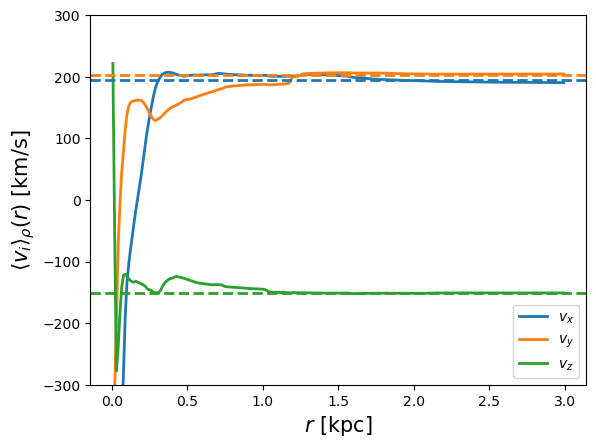

In [92]:
plt.plot(r_1d/const.kpc, v_1d[X]/const.km, lw=2, label=r'$v_x$', color='C0')
plt.plot(r_1d/const.kpc, v_1d[Y]/const.km, lw=2, label=r'$v_y$', color='C1')
plt.plot(r_1d/const.kpc, v_1d[Z]/const.km, lw=2, label=r'$v_z$', color='C2')

plt.xlabel(r'$r$ [kpc]', fontsize=15)
plt.ylabel(r"$\langle v_i \rangle_{\rho}(r)$ [${\rm km/s}$]", fontsize=15)
plt.legend()
    
plt.axhline(y=v_bulk[X]/const.km, lw=2, linestyle='--', color='C0')
plt.axhline(y=v_bulk[Y]/const.km, lw=2, linestyle='--', color='C1')
plt.axhline(y=v_bulk[Z]/const.km, lw=2, linestyle='--', color='C2')

plt.ylim(-300, 300)


In [93]:
vel_rel_bulk = sim.vel_vec - np.array([v_bulk[X], v_bulk[Y], v_bulk[Z]])[:, None, None, None]
l_mom = np.cross(coord_rel_center, vel_rel_bulk, axisa=0, axisb=0, axisc=0)

r_1d, lx_gas_1d = calc_profile1d(r_center, l_mom[X], vmin=0, vmax=3*const.kpc, do_log=False, nbin=256, weight=sim.density, do_cum=True)
r_1d, ly_gas_1d = calc_profile1d(r_center, l_mom[Y], vmin=0, vmax=3*const.kpc, do_log=False, nbin=256, weight=sim.density, do_cum=True)
r_1d, lz_gas_1d = calc_profile1d(r_center, l_mom[Z], vmin=0, vmax=3*const.kpc, do_log=False, nbin=256, weight=sim.density, do_cum=True)

vel_star_rel_bulk = vel_star_grid - np.array([v_bulk[X], v_bulk[Y], v_bulk[Z]])[:, None, None, None]
l_mom = np.cross(coord_rel_center, vel_rel_bulk, axisa=0, axisb=0, axisc=0)

r_1d, lx_star_1d = calc_profile1d(r_center, l_mom[X], vmin=0, vmax=3*const.kpc, do_log=False, nbin=256, weight=sim.density_star, do_cum=True)
r_1d, ly_star_1d = calc_profile1d(r_center, l_mom[Y], vmin=0, vmax=3*const.kpc, do_log=False, nbin=256, weight=sim.density_star, do_cum=True)
r_1d, lz_star_1d = calc_profile1d(r_center, l_mom[Z], vmin=0, vmax=3*const.kpc, do_log=False, nbin=256, weight=sim.density_star, do_cum=True)

lx_1d = lx_gas_1d + lx_star_1d
ly_1d = ly_gas_1d + ly_star_1d
lz_1d = lz_gas_1d + lz_star_1d

jx_1d = lx_1d / np.sqrt(lx_1d**2 + ly_1d**2 + lz_1d**2)
jy_1d = ly_1d / np.sqrt(lx_1d**2 + ly_1d**2 + lz_1d**2)
jz_1d = lz_1d / np.sqrt(lx_1d**2 + ly_1d**2 + lz_1d**2)
j_1d = np.array([jx_1d, jy_1d, jz_1d])


(0.0, 1.0)

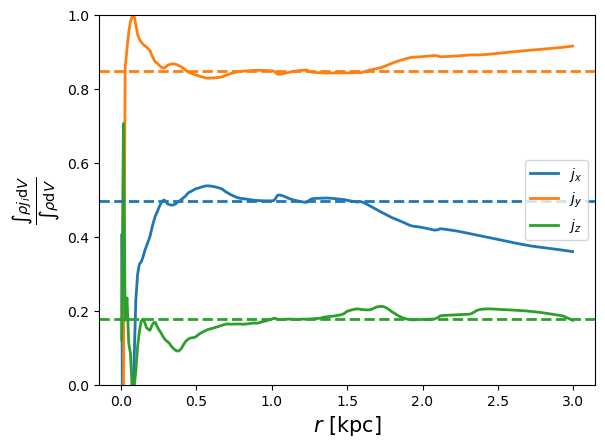

In [94]:
plt.plot(r_1d / const.kpc, jx_1d, lw=2, label=r'$j_x$', color='C0')
plt.plot(r_1d / const.kpc, jy_1d, lw=2, label=r'$j_y$', color='C1')
plt.plot(r_1d / const.kpc, jz_1d, lw=2, label=r'$j_z$', color='C2')

plt.xlabel(r'$r$ [kpc]', fontsize=15)
plt.ylabel(r"$\frac{\int \rho j_i {\rm d}V}{\int \rho {\rm d}V}$", fontsize=15)
plt.legend()

j_disk = np.zeros(3)
j_disk[X] = jx_1d[85]
j_disk[Y] = jy_1d[85]
j_disk[Z] = np.sqrt(1-j_disk[X]**2-j_disk[Y]**2)

plt.axhline(y=j_disk[X], lw=2, linestyle='--', color='C0')
plt.axhline(y=j_disk[Y], lw=2, linestyle='--', color='C1')
plt.axhline(y=j_disk[Z], lw=2, linestyle='--', color='C2')

plt.ylim(0, 1)


In [95]:
size_img = 2*const.kpc
size_sample = 2*const.kpc
num_pxl = 256
num_sample = 20000
vec_camera_edge = np.cross(j_disk, np.array([1, 0, 0]))
vec_camera_face = j_disk
vec_north = np.array([0.5, 0.5, 0])

vec_coord1, vec_coord2, im_gas_edge = sim.proj_anyaxis(sim.density, size_img, size_sample, vec_camera_edge, vec_north, coord_center, num_pxl, num_sample, weight=size_sample/num_sample, do_avg=False)
vec_coord1, vec_coord2, im_gas_face = sim.proj_anyaxis(sim.density, size_img, size_sample, vec_camera_face, vec_north, coord_center, num_pxl, num_sample, weight=size_sample/num_sample, do_avg=False)
vec_coord1, vec_coord2, im_star_edge = sim.proj_anyaxis(sim.density_star, size_img, size_sample, vec_camera_edge, vec_north, coord_center, num_pxl, num_sample, weight=size_sample/num_sample, do_avg=False)
vec_coord1, vec_coord2, im_star_face = sim.proj_anyaxis(sim.density_star, size_img, size_sample, vec_camera_face, vec_north, coord_center, num_pxl, num_sample, weight=size_sample/num_sample, do_avg=False)


In [96]:
size_img = 2*const.kpc
size_sample = 2*const.kpc
num_pxl = 16
num_sample = 20000
vec_camera_edge = np.cross(j_disk, np.array([1, 0, 0]))
vec_camera_face = j_disk
vec_north = np.array([0.5, 0.5, 0])

vec_coord1_edge, vec_coord2_edge, coord_pxl_edge = sim.getimgplane_anyaxis(size_img, vec_camera_edge, vec_north=vec_north, coord_center=coord_center, num_pxl=num_pxl)
vec_coord1_face, vec_coord2_face, coord_pxl_face = sim.getimgplane_anyaxis(size_img, vec_camera_face, vec_north=vec_north, coord_center=coord_center, num_pxl=num_pxl)

vel_rel_bulk = sim.vel_vec - np.array([v_bulk[X], v_bulk[Y], v_bulk[Z]])[:, None, None, None]
vel_coord1_edge = np.sum(vel_rel_bulk*vec_coord1_edge[:,None,None,None], axis=0)
vel_coord1_face = np.sum(vel_rel_bulk*vec_coord1_face[:,None,None,None], axis=0)
vel_coord2_edge = np.sum(vel_rel_bulk*vec_coord2_edge[:,None,None,None], axis=0)
vel_coord2_face = np.sum(vel_rel_bulk*vec_coord2_face[:,None,None,None], axis=0)

_, _, v1_edge = sim.proj_anyaxis(vel_coord1_edge, size_img, size_sample, vec_camera_edge, vec_north, coord_center, num_pxl, num_sample, weight=sim.density, do_avg=True)
_, _, v1_face = sim.proj_anyaxis(vel_coord1_face, size_img, size_sample, vec_camera_face, vec_north, coord_center, num_pxl, num_sample, weight=sim.density, do_avg=True)
_, _, v2_edge = sim.proj_anyaxis(vel_coord2_edge, size_img, size_sample, vec_camera_edge, vec_north, coord_center, num_pxl, num_sample, weight=sim.density, do_avg=True)
_, _, v2_face = sim.proj_anyaxis(vel_coord2_face, size_img, size_sample, vec_camera_face, vec_north, coord_center, num_pxl, num_sample, weight=sim.density, do_avg=True)

vel_star_rel_bulk = vel_star_grid - np.array([v_bulk[X], v_bulk[Y], v_bulk[Z]])[:, None, None, None]
vel_star_coord1_edge = np.sum(vel_star_rel_bulk*vec_coord1_edge[:,None,None,None], axis=0)
vel_star_coord1_face = np.sum(vel_star_rel_bulk*vec_coord1_face[:,None,None,None], axis=0)
vel_star_coord2_edge = np.sum(vel_star_rel_bulk*vec_coord2_edge[:,None,None,None], axis=0)
vel_star_coord2_face = np.sum(vel_star_rel_bulk*vec_coord2_face[:,None,None,None], axis=0)

_, _, v1_star_edge = sim.proj_anyaxis(vel_star_coord1_edge, size_img, size_sample, vec_camera_edge, vec_north, coord_center, num_pxl, num_sample, weight=sim.density_star, do_avg=True)
_, _, v1_star_face = sim.proj_anyaxis(vel_star_coord1_face, size_img, size_sample, vec_camera_face, vec_north, coord_center, num_pxl, num_sample, weight=sim.density_star, do_avg=True)
_, _, v2_star_edge = sim.proj_anyaxis(vel_star_coord2_edge, size_img, size_sample, vec_camera_edge, vec_north, coord_center, num_pxl, num_sample, weight=sim.density_star, do_avg=True)
_, _, v2_star_face = sim.proj_anyaxis(vel_star_coord2_face, size_img, size_sample, vec_camera_face, vec_north, coord_center, num_pxl, num_sample, weight=sim.density_star, do_avg=True)


In [115]:
np.savez('/home/za9132/analysis/proj_highphot', im_gas_face=im_gas_face, im_gas_edge=im_gas_edge, im_star_face=im_star_face, im_star_edge=im_star_edge, scale1d=scale1d, psd1d_gas=psd1d_gas, psd1d_star=psd1d_star, v1_face=v1_face, v1_edge=v1_edge, v2_face=v2_face, v2_edge=v2_edge, v1_star_face=v1_star_face, v1_star_edge=v1_star_edge, v2_star_face=v2_star_face, v2_star_edge=v2_star_edge, j_disk=j_disk, v_bulk=v_bulk, coord_center=coord_center)


In [2]:
data = np.load('/home/za9132/analysis/proj_highphot.npz')
sim = Sim(9, "fiducial", "data_d52_l1_b5.npz")
im_gas_face = data['im_gas_face']
im_gas_edge = data['im_gas_edge']
im_star_face = data['im_star_face']
im_star_edge = data['im_star_edge']
scale1d = data['scale1d']
psd1d_gas = data['psd1d_gas']
psd1d_star = data['psd1d_star']
v1_face = data['v1_face']
v2_face = data['v2_face']
v1_edge = data['v1_edge']
v2_edge = data['v2_edge']
v1_star_face = data['v1_star_face']
v2_star_face = data['v2_star_face']
v1_star_edge = data['v1_star_edge']
v2_star_edge = data['v2_star_edge']
j_disk = data['j_disk']
v_bulk = data['v_bulk']
coord_center = data['coord_center']


Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.


In [3]:
pxl = 1
im_gas_face_sm = gaussian_filter(im_gas_face, pxl)
im_gas_edge_sm = gaussian_filter(im_gas_edge, pxl)
im_star_face_sm = gaussian_filter(im_star_face, pxl)
im_star_edge_sm = gaussian_filter(im_star_edge, pxl)


Saved figure as 'proj-100820242144.png'


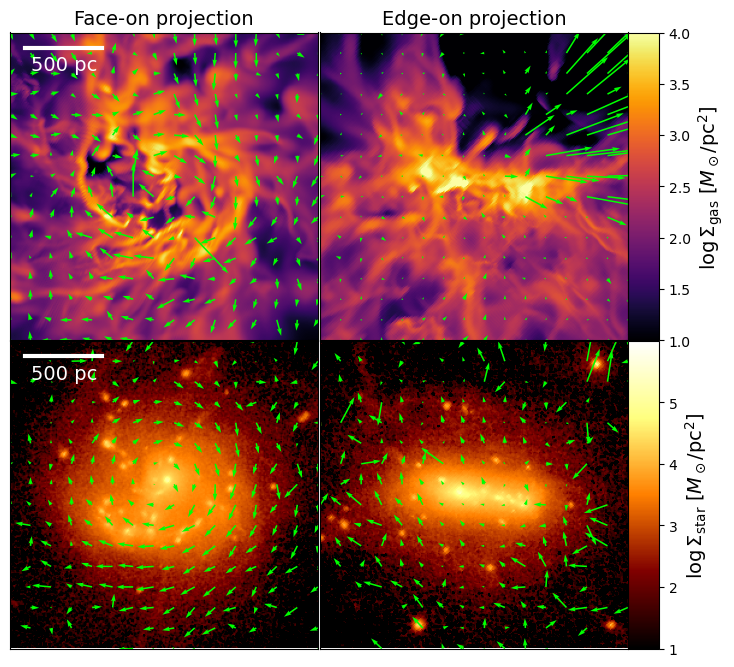

In [11]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
plt.subplots_adjust(hspace=1e-3, wspace=1e-3)

size_img = 2*const.kpc

im_gas = sim.plot_img(im_gas_face/(const.M_sol/const.pc**2), size_img, ax=axs[0, 0], cmap='inferno', do_log=True, vmin=1e1, vmax=1e4)
im_gas = sim.plot_img(im_gas_edge/(const.M_sol/const.pc**2), size_img, ax=axs[0, 1], cmap='inferno', do_log=True, vmin=1e1, vmax=1e4)
im_star = sim.plot_img(im_star_face/(const.M_sol/const.pc**2)+1e-30, size_img, ax=axs[1, 0], cmap='afmhot', do_log=True, vmin=1e1, vmax=1e6)
im_star = sim.plot_img(im_star_edge/(const.M_sol/const.pc**2)+1e-30, size_img, ax=axs[1, 1], cmap='afmhot', do_log=True, vmin=1e1, vmax=1e6)

dis = 500*const.pc
axs[0, 0].plot([-0.9*size_img/const.kpc/2, (-0.9*size_img/2 + dis)/const.kpc], [0.9*size_img/const.kpc/2, 0.9*size_img/const.kpc/2], lw=3, color='white')
axs[0, 0].annotate('%.3g %s' % (dis/const.pc, 'pc'), ((-0.9*size_img + dis)/const.kpc/2, 0.85*size_img/2/const.kpc), color='white', horizontalalignment='center', verticalalignment='top', fontsize=14)
axs[1, 0].plot([-0.9*size_img/const.kpc/2, (-0.9*size_img/2 + dis)/const.kpc], [0.9*size_img/const.kpc/2, 0.9*size_img/const.kpc/2], lw=3, color='white')
axs[1, 0].annotate('%.3g %s' % (dis/const.pc, 'pc'), ((-0.9*size_img + dis)/const.kpc/2, 0.85*size_img/2/const.kpc), color='white', horizontalalignment='center', verticalalignment='top', fontsize=14)

for i in range(2):
    for j in range(2):
        ax = axs[i, j]
        ax.set_xticks([])
        ax.set_yticks([])

cax = axs[0, 1].inset_axes([1, 0, 0.1, 1])
cbar = plt.colorbar(im_gas, cax=cax)
cbar.set_label(r'$\log \Sigma_{\rm gas}$ [$M_\odot/{\rm pc}^2$]', fontsize=14)

cax = axs[1, 1].inset_axes([1, 0, 0.1, 1])
cbar = plt.colorbar(im_star, cax=cax, ticks=[1, 2, 3, 4, 5])
cbar.set_label(r'$\log \Sigma_{\rm star}$ [$M_\odot/{\rm pc}^2$]', fontsize=14)

axs[0, 0].set_title('Face-on projection', fontsize=14)
axs[0, 1].set_title('Edge-on projection', fontsize=14)

coord1_1d = np.linspace(-const.pc, const.pc, 16)
coord2_1d = np.linspace(-const.pc, const.pc, 16)
coord1_2d, coord2_2d = np.meshgrid(coord1_1d, coord2_1d, indexing='ij')
axs[0, 0].quiver(coord1_2d/const.pc, coord2_2d/const.pc, v1_face, v2_face, color='lime', width=0.005)
axs[0, 1].quiver(coord1_2d/const.pc, coord2_2d/const.pc, v1_edge, v2_edge, color='lime', width=0.005)
axs[1, 0].quiver(coord1_2d/const.pc, coord2_2d/const.pc, v1_star_face, v2_star_face, color='lime', width=0.005)
axs[1, 1].quiver(coord1_2d/const.pc, coord2_2d/const.pc, v1_star_edge, v2_star_edge, color='lime', width=0.005)

save_fig('proj')


In [4]:
v3 = j_disk
v_north = np.array([1, 0, 0])
v2 = np.cross(v3, v_north)
v2 = v2 / np.sqrt(np.sum(v2**2))
v1 = np.cross(v2, v3)
v1 = v1 / np.sqrt(np.sum(v1**2))


In [5]:
coord = sim.coord - coord_center[:, None, None, None]
x1 = np.sum(coord * v1[:, None, None, None], axis=0)
x2 = np.sum(coord * v2[:, None, None, None], axis=0)
x3 = np.sum(coord * v3[:, None, None, None], axis=0)
s = np.sqrt(x1**2 + x2**2)
r = np.sqrt(x1**2 + x2**2 + x3**2)


In [7]:
vel_vec = sim.vel_vec - v_bulk[:, None, None, None]
vel_1 = np.sum(vel_vec * v1[:, None, None, None], axis=0)
vel_2 = np.sum(vel_vec * v2[:, None, None, None], axis=0)
vel_3 = np.sum(vel_vec * v3[:, None, None, None], axis=0)

v_phi = (x1 * vel_2 - x2 * vel_1) / s
v_r = (x1 * vel_1 + x2 * vel_2) / s


In [6]:
def calc_frac(h_disk, r_disk, density_int, cond_temp=None):
    if type(cond_temp) == type(None): cond_temp = np.ones_like(s)
    cond = (np.abs(x3) < h_disk) * (s < r_disk) * cond_temp
    return np.sum(density * cond) / density_int

def calc_r_disk(h_disk, density_int, cond_temp, niter=10, r_disk_low=0, r_disk_high=const.kpc):
    for i in range(niter):
        r_disk_mid = (r_disk_low + r_disk_high) / 2
        frac = calc_frac(h_disk, r_disk_mid, density_int, cond_temp)
        if frac_goal <= frac:
            r_disk_high = r_disk_mid
        else:
            r_disk_low = r_disk_mid
    return (r_disk_low + r_disk_high) / 2

def calc_h_disk(r_disk, density_int, cond_temp, niter=10, h_disk_low=0, h_disk_high=const.kpc):
    for i in range(niter):
        h_disk_mid = (h_disk_low + h_disk_high) / 2
        frac = calc_frac(h_disk_mid, r_disk, density_int, cond_temp)
        if frac_goal <= frac:
            h_disk_high = h_disk_mid
        else:
            h_disk_low = h_disk_mid
    return (h_disk_low + h_disk_high) / 2

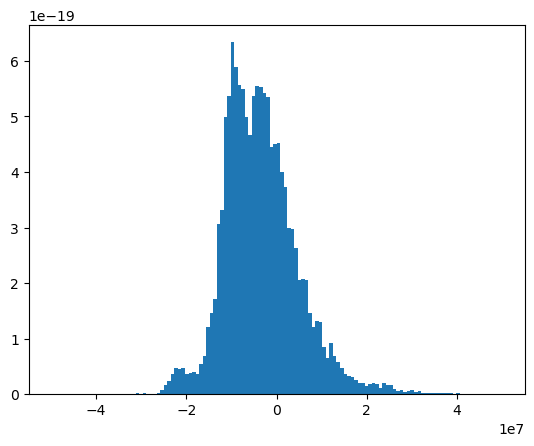

In [17]:
cond = (np.abs(x3) < h_disk) * (s < r_disk_max)
plt.hist(v_r.flatten(), bins=128, weights=(sim.density * cond).flatten(), range=(-0.5e8, 0.5e8));


In [8]:
density = sim.density

h_disk = const.kpc
r_disk_max = const.kpc
cond_temp = (sim.temp < 10000)
frac_goal = 0.85

for i in range(5):

    cond = (np.abs(x3) < h_disk) * (s < r_disk_max) * cond_temp * (v_r < 0)
    density_int = np.sum(density * cond)
    r_disk = calc_r_disk(h_disk, density_int, cond_temp)

    cond = (np.abs(x3) < r_disk) * (s < r_disk) * cond_temp * (v_r < 0)
    density_int = np.sum(density * cond)
    h_disk = calc_h_disk(r_disk, density_int, cond_temp)
    
    print("%.3g, %.3g" % (h_disk/const.pc, r_disk/const.pc))
    
print(h_disk/r_disk)


71.8, 498
69.8, 481
69.8, 481
69.8, 481


KeyboardInterrupt: 

In [37]:
h_disk = 326 * const.pc
r_disk = 696 * const.pc


In [54]:
bins = int(r_disk / (25 * const.pc))
cond = (np.abs(x3) < h_disk) * (s < r_disk) * (sim.temp < 10000)
srange = (0, r_disk)
s_list = np.linspace(srange[0], srange[1], bins+1)
v_phi_sig_r_1d = np.zeros(bins)

for i in np.arange(bins):
    
    cond_s = (s > s_list[i]) * (s < s_list[i + 1]) * cond
    v_r_avg = np.sum(v_r * sim.density * cond_s) / np.sum(sim.density * cond_s)
    v_r_rel = v_r - v_r_avg
    sig_r = np.sqrt(np.sum(v_r_rel**2 * sim.density * cond_s) / np.sum(sim.density * cond_s))
    v_phi_sig_r_1d[i] = np.sum(v_phi / sig_r * sim.density * cond_s)
    print(i, end=", ")


In [44]:
np.sum(v_phi_sig_r_1d) / np.sum(sim.density * cond)


2.164644233927131

In [17]:
density = sim.density_star

h_disk = const.kpc
r_disk_max = const.kpc
frac_goal = 0.85

for i in np.arange(5):

    cond = (np.abs(x3) < h_disk) * (s < r_disk_max)
    density_int = np.sum(density * cond)
    r_disk = calc_r_disk(h_disk, density_int)

    cond = (np.abs(x3) < r_disk) * (s < r_disk)
    density_int = np.sum(density * cond)
    h_disk = calc_h_disk(r_disk, density_int)
    
    print("%.3g, %.3g" % (h_disk/const.pc, r_disk/const.pc))
    
print(h_disk/r_disk)


122, 487
116, 434
115, 431
115, 431
115, 431
0.26613816534541335


In [49]:
h_disk = 115 * const.pc
r_disk = 431 * const.pc


In [50]:
coord = sim.coord_star - coord_center[:, None]
x1 = np.sum(sim.coord_star * v1[:, None], axis=0)
x2 = np.sum(sim.coord_star * v2[:, None], axis=0)
x3 = np.sum(sim.coord_star * v3[:, None], axis=0)
s = np.sqrt(x1**2 + x2**2)
r = np.sqrt(x1**2 + x2**2 + x3**2)

vel_vec = sim.vel_star - v_bulk[:, None, None, None]
vel_1 = np.sum(vel_vec * v1[:, None], axis=0)
vel_2 = np.sum(vel_vec * v2[:, None], axis=0)
vel_3 = np.sum(vel_vec * v3[:, None], axis=0)

v_phi = (x1 * vel_2 - x2 * vel_1) / s
v_r = (x1 * vel_1 + x2 * vel_2) / s


In [52]:
bins = int(r_disk / (25 * const.pc))
cond = (np.abs(x3) < h_disk) * (s < r_disk)
srange = (0, r_disk)
s_list = np.linspace(srange[0], srange[1], bins+1)
v_phi_sig_r_1d = np.zeros(bins)

for i in np.arange(bins):
    
    cond_s = (s > s_list[i]) * (s < s_list[i + 1]) * cond
    v_r_avg = np.sum(v_r * sim.mass_star * cond_s) / np.sum(sim.mass_star * cond_s)
    v_r_rel = v_r - v_r_avg
    sig_r = np.sqrt(np.sum(v_r_rel**2 * sim.mass_star * cond_s) / np.sum(sim.mass_star * cond_s))
    v_phi_sig_r_1d[i] = np.sum(v_phi / sig_r * sim.mass_star * cond_s)
    print(i, end=", ")


0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 

In [53]:
np.sum(v_phi_sig_r_1d) / np.sum(sim.mass_star * cond)


0.9188164854655152

In [33]:
size_img = 2*const.kpc
size_sample = 2*const.kpc
num_pxl = 256
num_sample = 2048
vec_camera_edge = np.cross(j_disk, np.array([1, 0, 0]))
vec_camera_face = j_disk
vec_north = np.array([0.5, 0.5, 0])

kappa = 5*sim.metallicity/const.Z_sol

vec_coord1, vec_coord2, im_b0p0 = sim.proj_anyaxis(kappa*sim.density, size_img, size_sample, vec_camera_face, vec_north, coord_center, num_pxl, num_sample, weight=size_sample/num_sample, do_avg=False)
vec_coord1, vec_coord2, im_b0p3 = sim.proj_anyaxis(kappa*sim.density/((1+(1/3)**2*sim.mach_turb**2)**(np.exp(0.2))), size_img, size_sample, vec_camera_face, vec_north, coord_center, num_pxl, num_sample, weight=size_sample/num_sample, do_avg=False)
vec_coord1, vec_coord2, im_b1p0 = sim.proj_anyaxis(kappa*sim.density/((1+sim.mach_turb**2)**np.exp(0.38)), size_img, size_sample, vec_camera_face, vec_north, coord_center, num_pxl, num_sample, weight=size_sample/num_sample, do_avg=False)


Saved figure as 'opacityIR-052420241729.png'


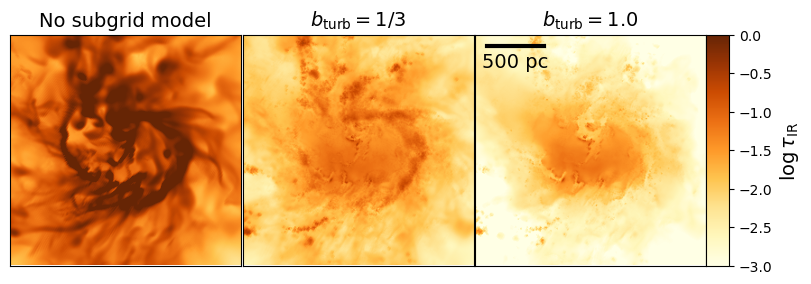

In [34]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
plt.subplots_adjust(hspace=1e-3, wspace=1e-3)

label_list = [r'No subgrid model', r'$b_{\rm turb} = 1/3$', r'$b_{\rm turb} = 1.0$']

im = sim.plot_img(im_b0p0, ax=axs[0], do_log=True, cmap='YlOrBr', vmin=10**(-3), vmax=10**(0), size_img=size_img)
im = sim.plot_img(im_b0p3, ax=axs[1], do_log=True, cmap='YlOrBr', vmin=10**(-3), vmax=10**(0), size_img=size_img)
im = sim.plot_img(im_b1p0, ax=axs[2], do_log=True, cmap='YlOrBr', vmin=10**(-3), vmax=10**(0), size_img=size_img)

for i in range(3):
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].set_title(label_list[i], fontsize=14)

axs[-1].plot([-0.9*size_img/const.kpc/2, (-0.9*size_img/2 + 500*const.pc)/const.kpc], [0.9*size_img/const.kpc/2, 0.9*size_img/const.kpc/2], lw=3, color='black')
axs[-1].annotate('500 pc', ((-0.9*size_img + 500*const.pc)/const.kpc/2, 0.85*size_img/2/const.kpc), color='black', horizontalalignment='center', verticalalignment='top', fontsize=14)
cax = axs[-1].inset_axes([1, 0, 0.1, 1])
cbar = plt.colorbar(im, cax=cax)
cbar.set_label(r'$\log \tau_{\rm IR}$', fontsize=14)
    
save_fig('opacityIR')
    

Moving to directory '/home/za9132/scratch/romain/round9/mstar0p2'.
Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.
Moving to directory '/home/za9132/scratch/romain/round9/mstar5p0'.
Moving to directory '/home/za9132/scratch/romain/round12/nophot'.
Saved figure as 'gaspropcomp-091820241307.png'


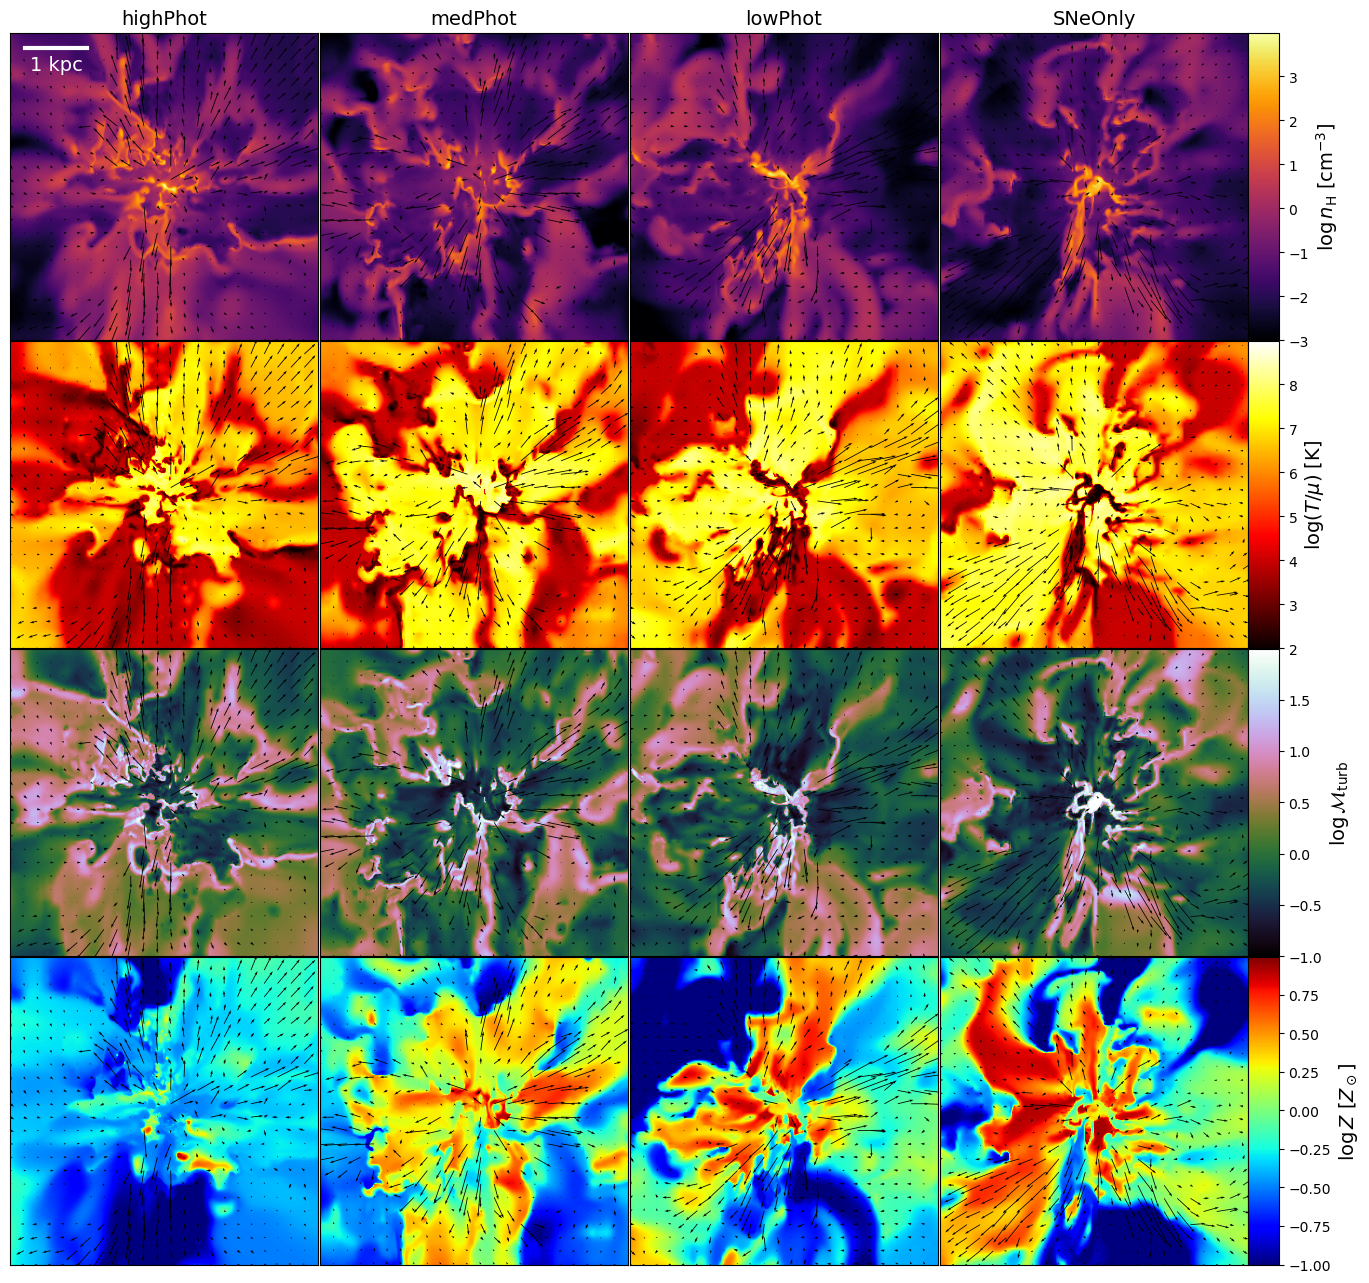

In [33]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(16, 16))
plt.subplots_adjust(wspace=1e-3, hspace=1e-3)
size_img = 5*const.kpc

sim_list  = [(9, "mstar0p2"), (9, "fiducial"), (9, "mstar5p0"), (12, "nophot")]
npz_list  = ["data_d47_l1_b5.npz", "data_d52_l1_b5.npz", "data_d45_l1_b5.npz", "data_d53_l1_b5.npz"]
lbl_list  = ['highPhot', 'medPhot', 'lowPhot', 'SNeOnly']
var_list  = ['n_H', 'temp', 'mach_turb', 'metallicity']
clbl_list = [r'$\log n_{\rm H}$ [${\rm cm^{-3}}$]', r'$\log (T/\mu)$ [${\rm K}$]', r'$\log \mathcal{M}_{\rm turb}$', r'$\log Z$ [$Z_\odot$]']
rng_list  = [(1e-3, 1e4), (1e2, 1e9), (1e-1, 1e2), (1e-1, 1e1)]
cmap_list = ['inferno', 'hot', 'cubehelix', 'jet']
unit_list = [1, 1, 1, const.Z_sol]

for i in range(4):

    sim_round, sim_name = sim_list[i]
    sim = Sim(sim_round, sim_name, npz_list[i])
    axs[0, i].set_title(lbl_list[i], fontsize=14)
    
    skip = 16
    vely_rel_bulk = sim.vel_vec[Y] - np.sum(sim.density*sim.vel_vec[Y])/np.sum(sim.density)
    velz_rel_bulk = sim.vel_vec[Z] - np.sum(sim.density*sim.vel_vec[Z])/np.sum(sim.density)
    img_c1 = sim.slice_axis(sim.coord[Y], idx_axis=X, size_img=size_img)
    img_c2 = sim.slice_axis(sim.coord[Z], idx_axis=X, size_img=size_img)
    img_v1 = sim.slice_axis(vely_rel_bulk, idx_axis=X, size_img=size_img)
    img_v2 = sim.slice_axis(velz_rel_bulk, idx_axis=X, size_img=size_img)
    
    for j in range(4):
        
        var  = var_list[j]
        rng  = rng_list[j]
        cmap = cmap_list[j]
        unit = unit_list[j]
        clbl = clbl_list[j]
        ax = axs[j, i]

        img_var = sim.slice_axis(var, idx_axis=X, size_img=size_img)
        im = sim.plot_img(img_var/unit, ax=ax, do_log=True, cmap=cmap, vmin=rng[0], vmax=rng[1]*0.99, size_img=size_img)
        ax.quiver(img_c1[::skip, ::skip]/const.kpc, img_c2[::skip, ::skip]/const.kpc, img_v1[::skip, ::skip], img_v2[::skip, ::skip])

        ax.set_xticks([])
        ax.set_yticks([])
        
        if i==3:
            cax = ax.inset_axes([1, 0, 0.1, 1])
            cbar = plt.colorbar(im, cax=cax)
            cbar.set_label(clbl, fontsize=14)
        
sim.add_dis_to_ax(axs[0, 0], 1*const.kpc, size_img=size_img)

save_fig('gaspropcomp')


In [2]:
Harikane23 = SimpleNamespace(
    link='https://arxiv.org/pdf/2304.06658',
    survey=np.array(['JADES', 'JADES', 'JADES', 'CEERS', 'CEERS', 'JADES', 'CEERS', 'CEERS', 'CEERS', 'CEERS', 'CEERS']),
    id=np.array(['GS-z13-0', 'GS-z12-0', 'GS-z11-0', "Maisie's Galaxy", 'CEERS2_588', 'GS-z10-0', 'CEERS2_7929', 'CEERS-24', 'CEERS-23', 'CEERS1_6059', 'CEERS1_3858']),
    z=np.array([13.2, 12.63, 11.58, 11.4, 11.04, 10.38, 10.1, 8.998, 8.881, 8.876, 8.807]),
    SFR=np.array([0.5, 0.5, 1.8, 0.8, 12.7, 1.6, 5.9, 1.9, 1.1, 8.8, 3.6]),
    SFR_p=np.array([0.7, 1.3, 0.4, 2.1, 9.7, 0.6, 1.6, 1.9, 2.9, 2.4, 1.9]),
    SFR_m=np.array([0.1, 0.1, 0.5, 0.1, 4.9, 0.2, 2.6, 0.4, 0.3, 2.1, 0.4]),
    Mstar=np.array([5.1e7, 4.3e8, 1.2e9, 6.1e7, 9.9e8, 2.0e8, 4.6e8, 9.8e7, 7.6e7, 9.6e8, 2.3e8]),
    Mstar_p=np.array([21.2e7, 1.8e8, 0.1e9, 23.5e7, 23.9e8, 0.6e8, 5.5e8, 51.2e7, 50.4e7, 1.7e8, 2.7e8]),
    Mstar_m=np.array([1.2e7, 2.0e8, 0.3e9, 1.4e7, 4.0e8, 0.4e8, 1.7e8, 0.1e7, 1.5e7, 2.1e8, 0.3e8])
)
Harikane23.sSFR = Harikane23.SFR/Harikane23.Mstar
Harikane23.sSFR_p = Harikane23.sSFR*np.sqrt((Harikane23.SFR_p/Harikane23.SFR)**2+(Harikane23.Mstar_p/Harikane23.Mstar)**2)
Harikane23.sSFR_m = Harikane23.sSFR*np.sqrt((Harikane23.SFR_m/Harikane23.SFR)**2+(Harikane23.Mstar_m/Harikane23.Mstar)**2)

Casey24 = SimpleNamespace(
    link='https://arxiv.org/pdf/2308.10932',
    id=np.array(['COS-z10-1', 'COS-z12-1', 'COS-z12-2', 'COS-z12-3', 'COS-z10-2', 'COS-z10-3', 'COS-z10-4', 'COS-z11-1', 'COS-z11-2', 'COS-z13-1', 'COS-z13-2', 'COS-z14-1']),
    z=np.array([9.69, 12.08, 11.46, 11.46, 9.15, 9.82, 10.2, 11.19, 10.63, 13.2, 13.4, 14.0]),
    z_p=np.array([0.24, 0.13, 0.42, 0.28, 0.29, 0.22, 0.51, 0.31, 0.52, 0.6, 0.7, 1.1]),
    z_m=np.array([0.25, 0.16, 0.04, 0.23, 0.35, 0.45, 0.54, 0.30, 0.46, 0.9, 01.2, 1.5]),
    SFR=np.array([30, 39, 31, 54, 44, 18, 18, 16, 15, 5.6, 5.4, 5.0]),
    SFR_p=np.array([8, 10, 22, 16, 13, 7, 7, 5, 4, 2.7, 1.9, 1.4]),
    SFR_m=np.array([8, 16, 12, 16, 20, 4, 6, 6, 9, 3.3, 3.1, 2.6]),
    Mstar=np.array([3.7e9, 4.0e9, 4.8e9, 5.6e9, 1.1e10, 1.8e9, 1.9e9, 1.7e9, 1.6e9, 5.9e8, 5.6e8, 5.1e8]),
    Mstar_p=np.array([2.2e9, 1.4e9, 5.3e9, 1.7e9, 0.7e10, 0.7e9, 1.0e9, 0.9e9, 0.9e9, 5.0e8, 3.4e8, 2.8e8]),
    Mstar_m=np.array([1.4e9, 1.3e9, 2.3e9, 1.4e9, 0.3e10, 0.4e9, 0.4e9, 0.6e9, 0.5e9, 2.1e8, 2.2e8, 1.8e8])
)
Casey24.sSFR = Casey24.SFR/Casey24.Mstar
Casey24.sSFR_p = Casey24.sSFR*np.sqrt((Casey24.SFR_p/Casey24.SFR)**2+(Casey24.Mstar_p/Casey24.Mstar)**2)
Casey24.sSFR_m = Casey24.sSFR*np.sqrt((Casey24.SFR_m/Casey24.SFR)**2+(Casey24.Mstar_m/Casey24.Mstar)**2)

Carniani24 = SimpleNamespace(
    link='https://arxiv.org/pdf/2405.18485',
    id=np.array(['GS-z14-0', 'GS-z14-1']),
    z=np.array([14.32, 13.9]),
    z_p=np.array([0.08, 0.17]),
    z_m=np.array([0.20, 0.17]),
    Mstar=np.array([5.01e8, 1.0e8]),
    Mstar_p=np.array([2.01e9, 1.51e8]),
    Mstar_m=np.array([1.85e8, 4.99e7]),
    SFR=np.array([5, 1.2]),
    SFR_p=np.array([9, 0.7]),
    SFR_m=np.array([3, 0.9]),
    SFR10=np.array([22, 2]),
    SFR10_p=np.array([6, 0.7]),
    SFR10_m=np.array([6, 0.4]),
    sSFR10=np.array([45, 18]),
    sSFR10_p=np.array([56, 75]),
    sSFR10_m=np.array([35, 38]),
    Z=np.array([0.0316, 0.794])*const.Z_sol,
    Z_p=np.array([0.127, 0.237])*const.Z_sol,
    Z_m=np.array([0.019, 0.0595])*const.Z_sol
)

data = np.load('/home/za9132/analysis/SFR.npz', allow_pickle=True)
time = data['time']
SFR_list = data['SFR_list']
Mstar_list = data['Mstar_list']


In [9]:
aexp_list = np.linspace(1e-3, 1., 2**10)
time_list = np.array([aexp_to_proper_time(aexp_list[i]) for i in range(len(aexp_list))])
proper_time_to_aexp_interp = interp1d(time_list, aexp_list, fill_value='extrapolate')

aexp = proper_time_to_aexp_interp(time)
redshift = 1/aexp-1

dt = 0.1*const.Myr
sigma_idx = int(50*const.Myr/dt)
window50 = np.zeros(2*sigma_idx-1)
window50[sigma_idx:] = 1/sigma_idx

sigma_idx = int(10*const.Myr/dt)
window10 = np.zeros(2*sigma_idx-1)
window10[sigma_idx:] = 1/sigma_idx
SFR10_fid = np.convolve(SFR_list[0][1], window10, mode='same')

SFR_list_red = np.array([SFR_list[0][0], SFR_list[0][1], SFR_list[0][2], SFR_list[2][0], SFR_list[2][1]])
Mstar_list_red = np.array([Mstar_list[0][0], Mstar_list[0][1], Mstar_list[0][2], Mstar_list[2][0], Mstar_list[2][1]])
SFR10_list_red = []
SFR50_list_red = []
for i in range(5): 
    SFR10_list_red.append(np.convolve(SFR_list_red[i], window10, mode='same'))
    SFR50_list_red.append(np.convolve(SFR_list_red[i], window50, mode='same'))

SFR_fid = SFR50_list_red[1]
Mstar_fid = Mstar_list_red[1]
SFR_min = np.minimum.reduce(SFR50_list_red)
SFR_max = np.maximum.reduce(SFR50_list_red)
Mstar_min = np.minimum.reduce(Mstar_list_red)
Mstar_max = np.maximum.reduce(Mstar_list_red)


In [44]:
import sys
from astropy.io import ascii

formats = {
    'time[Myr]': '%.3f',
    'redshift': '%.4f',
    'Mstar[1e9Msol]': '%.5f',
    'SFR[Msol/yr]': '%.4f',
    'SFR10[Msol/yr]': '%.4f',
    'SFR50[Msol/yr]': '%.4f'
}
sim_name_list = ["highPhot", "fiducial", "lowPhot", "solTurb", "varTurb"]
path = "/home/za9132/analysis/data"

for i in range(5):

    table = {
        "time[Myr]": time/const.Myr,
        "redshift": redshift,
        "Mstar[1e9Msol]": Mstar_list_red[i]/const.M_sol/1e9,
        "SFR[Msol/yr]": SFR_list_red[i]/(const.M_sol/const.yr),
        "SFR10[Msol/yr]": SFR10_list_red[i]/(const.M_sol/const.yr),
        "SFR50[Msol/yr]": SFR50_list_red[i]/(const.M_sol/const.yr)
    }

    ascii.write(table, os.path.join(path, sim_name_list[i] + ".csv"), formats=formats, delimiter=',', overwrite=True)


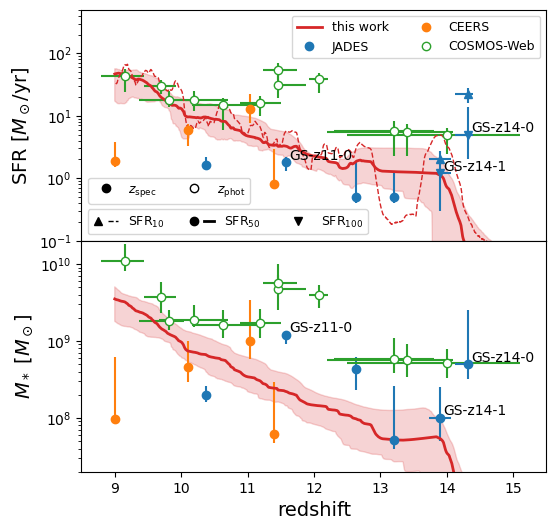

In [10]:
fig, axs = plt.subplots(nrows=2, figsize=(6, 6), sharex=True)
plt.subplots_adjust(wspace=1e-3, hspace=1e-3)

axs[0].errorbar(Harikane23.z[Harikane23.survey=='JADES'], Harikane23.SFR[Harikane23.survey=='JADES'], yerr=(Harikane23.SFR_m[Harikane23.survey=='JADES'], Harikane23.SFR_p[Harikane23.survey=='JADES']), marker='o', linestyle='', label='JADES')
axs[0].errorbar(Harikane23.z[Harikane23.survey=='CEERS'][:4], Harikane23.SFR[Harikane23.survey=='CEERS'][:4], yerr=(Harikane23.SFR_m[Harikane23.survey=='CEERS'][:4], Harikane23.SFR_p[Harikane23.survey=='CEERS'][:4]), marker='o', linestyle='', label='CEERS')
axs[0].errorbar(Casey24.z, Casey24.SFR, xerr=(Casey24.z_m, Casey24.z_p), yerr=(Casey24.SFR_m, Casey24.SFR_p), marker='o', linestyle='', mfc='white', label='COSMOS-Web')
axs[0].errorbar(Carniani24.z, Carniani24.SFR, xerr=(Carniani24.z_m, Carniani24.z_p), yerr=(Carniani24.SFR_m, Carniani24.SFR_p), marker='v', linestyle='', color='C0')
axs[0].errorbar(Carniani24.z, Carniani24.SFR10, xerr=(Carniani24.z_m, Carniani24.z_p), yerr=(Carniani24.SFR10_m, Carniani24.SFR10_p), marker='^', linestyle='', color='C0')

axs[0].plot(redshift, SFR_fid/(const.M_sol/const.yr), lw=2, color='C3', label='this work')
axs[0].plot(redshift, SFR10_fid/(const.M_sol/const.yr), lw=1, color='C3', linestyle='--')
axs[0].fill_between(redshift, SFR_min/(const.M_sol/const.yr), SFR_max/(const.M_sol/const.yr), color='C3', alpha=0.2)

axs[0].set_yscale('log')
axs[0].set_ylim(1e-1, 5e2)
axs[0].set_ylabel(r'SFR [$M_\odot/{\rm yr}$]', fontsize=14)

axs[1].errorbar(Harikane23.z[Harikane23.survey=='JADES'], Harikane23.Mstar[Harikane23.survey=='JADES'], yerr=(Harikane23.Mstar_m[Harikane23.survey=='JADES'], Harikane23.Mstar_p[Harikane23.survey=='JADES']), marker='o', linestyle='', label='JADES')
axs[1].errorbar(Harikane23.z[Harikane23.survey=='CEERS'][:4], Harikane23.Mstar[Harikane23.survey=='CEERS'][:4], yerr=(Harikane23.Mstar_m[Harikane23.survey=='CEERS'][:4], Harikane23.Mstar_p[Harikane23.survey=='CEERS'][:4]), marker='o', linestyle='', label='CEERS')
axs[1].errorbar(Casey24.z, Casey24.Mstar, xerr=(Casey24.z_m, Casey24.z_p), yerr=(Casey24.Mstar_m, Casey24.Mstar_p), marker='o', linestyle='', mfc='white', label='COSMOS-Web')
axs[1].errorbar(Carniani24.z, Carniani24.Mstar, xerr=(Carniani24.z_m, Carniani24.z_p), yerr=(Carniani24.Mstar_m, Carniani24.Mstar_p), marker='o', linestyle='', color='C0')

axs[1].plot(redshift, Mstar_fid/const.M_sol, lw=2, color='C3', label='this work')
axs[1].fill_between(redshift, Mstar_min/const.M_sol, Mstar_max/const.M_sol, color='C3', alpha=0.2)

anno_list = ['GS-z14-0', 'GS-z14-1', 'GS-z11-0']
for dataset in [Harikane23, Casey24, Carniani24]:
    for i, name in enumerate(dataset.id):
        if name in anno_list:
            axs[0].annotate(name, (dataset.z[i], dataset.SFR[i]), xytext=(2, 2), textcoords="offset points")
            axs[1].annotate(name, (dataset.z[i], dataset.Mstar[i]), xytext=(2, 2), textcoords="offset points")

axs[1].set_yscale('log')
axs[1].set_ylim(2e7, 2e10)

axs[1].set_xlabel('redshift', fontsize=14)
axs[1].set_ylabel(r'$M_*$ [$M_\odot$]', fontsize=14)

axs[0].set_xlim(8.5, 15.5)
axs[0].set_xlabel('redshift', fontsize=14)

from matplotlib.legend_handler import HandlerTuple
cust_line = [(Line2D([0], [0], color='black', marker='^', linestyle=''), Line2D([0], [0], color='black', marker='', lw=1, linestyle='--')), (Line2D([0], [0], color='black', marker='o', linestyle=''), Line2D([0], [0], color='black', marker='', linestyle='-', lw=2)), Line2D([0], [0], color='black', marker='v', linestyle='')]
cust_lbl  = [r'${\rm SFR_{10}}$', r'${\rm SFR_{50}}$', r'${\rm SFR_{100}}$']
leg1 = axs[0].legend(cust_line, cust_lbl, handler_map={tuple: HandlerTuple(ndivide=None)}, ncol=3, loc=3, fontsize=9)

cust_line = [Line2D([0], [0], color='black', marker='o', linestyle=''), Line2D([0], [0], color='black', marker='o', linestyle='', mfc='white')]
cust_lbl  = [r'$z_{\rm spec}$', r'$z_{\rm phot}$']
leg2 = axs[0].legend(cust_line, cust_lbl, ncol=2, loc=(0.015, 0.16), fontsize=9)

cust_line = [Line2D([0], [0], color='C3', lw=2), Line2D([0], [0], color='C0', marker='o', linestyle=''), Line2D([0], [0], color='C1', marker='o', linestyle=''), Line2D([0], [0], color='C2', marker='o', linestyle='', mfc='white')]
cust_lbl  = ['this work', 'JADES', 'CEERS', 'COSMOS-Web']
leg3 = axs[0].legend(cust_line, cust_lbl, ncol=2, fontsize=9)

axs[0].add_artist(leg1)
axs[0].add_artist(leg2)

#save_fig('obs_comp')


In [6]:
sim_list = [(9, "fiducial"), (13, "medturb"), (13, "lowturb")]
npz_list = ["data_d34_l2_b5.npz", "data_d32_l1_b5.npz", "data_d32_l1_b5.npz"]
nsim = len(sim_list)

dt = 0.1*const.Myr
nstep = 5583
eta = 0.2

tstart = 3*const.Myr
tend = 20*const.Myr
tstart_idx = int(tstart/dt)
tend_idx = int(tend/dt)

SFR_list = [np.zeros(nstep), np.zeros(nstep), np.zeros(nstep)]
Mstar_list = [np.zeros(nstep), np.zeros(nstep), np.zeros(nstep)]

window = np.zeros(2*nstep-1)
window[nstep:nstep+tstart_idx] = 1
window[nstep+tstart_idx:nstep+tend_idx] = np.linspace(1, 1-eta, tend_idx-tstart_idx)
window[nstep+tend_idx:] = 1-eta
window *= dt

for j in range(nsim):

    sim_round, sim_name = sim_list[j]
    sim = Sim(sim_round, sim_name, npz_list[j])

    time, SFR = calc_hist1d(sim.time_starbirth, vmin=0, vmax=558.3*const.Myr, nbin=5583, weight=sim.mass_star, do_log=False)
    SFR[::-1][tstart_idx:tend_idx] *= 1/np.linspace(1, 1-eta, tend_idx-tstart_idx)
    SFR[::-1][tend_idx:] *= 1/(1-eta)
    SFR_list[j] = SFR
    Mstar_list[j] = np.convolve(SFR, window, mode='valid')
        


Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.
Moving to directory '/home/za9132/scratch/romain/round13/medturb'.
Moving to directory '/home/za9132/scratch/romain/round13/lowturb'.


Saved figure as 'starmass-090320241102.png'


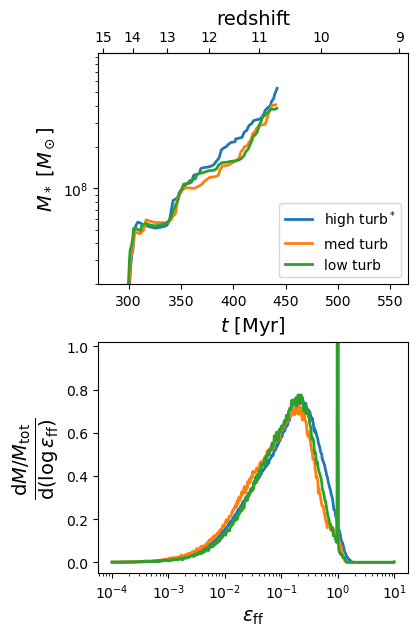

In [16]:
fig, ax1 = plt.subplots(figsize=(4, 3), sharey='row')
plt.subplots_adjust(hspace=1e-3, wspace=1e-3)
ax2 = ax1.inset_axes([0, -1.25, 1, 1])

z_min = 15.2
z_max = 8.9
tick_z = [15, 14, 13, 12, 11, 10, 9]

aexp_list = np.linspace(1e-3, 1., 2**10)
time_list = np.array([aexp_to_proper_time(aexp_list[i]) for i in range(len(aexp_list))])
proper_time_to_z_interp = interp1d(time_list/const.Myr, 1/aexp_list-1, fill_value='extrapolate')
z_to_proper_time_interp = interp1d(1/aexp_list-1, time_list/const.Myr, fill_value='extrapolate')

sim_list = [(9, "fiducial"), (13, "medturb"), (13, "lowturb")]
label_list = [r"high turb$^*$", r"med turb", r"low turb"]
color_list = ["C0", "C1", "C2"]

for i in range(len(label_list)):

    sim_round, sim_name = sim_list[i]
    move_to_sim_dir(sim_round, sim_name, do_print=False)
    data = SimpleNamespace(**np.load('starcat/data.npz'))

    SFR, Mstar = SFR_list[i], Mstar_list[i]
    cond = (SFR > 0)
    ax1.plot(time[cond]/const.Myr, Mstar[cond]/const.M_sol, lw=2., color=color_list[i])
    ax2.plot(data.eps_sf1d, data.eps_sf_pdf1d, lw=2, color=color_list[i])
    
axtop = ax1.secondary_xaxis('top', functions=(proper_time_to_z_interp, z_to_proper_time_interp))
axtop.set_xticks(tick_z)
axtop.set_xlabel(r'redshift', fontsize=14)
    
ax1.set_xlabel(r"$t$ [Myr]", fontsize=14)
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel(r"$\epsilon_{\rm ff}$", fontsize=14)
ax2.set_ylim(-0.05, 1.02)
ax1.set_xlim(z_to_proper_time_interp(z_min), z_to_proper_time_interp(z_max))
ax1.set_ylim(2e7)
    
ax1.set_ylabel(r"$M_*$ [$M_\odot$]", fontsize=14)
ax2.set_ylabel(r'$\frac{{\rm d} M/M_{\rm tot}}{{\rm d}(\log \epsilon_{\rm ff})}$', fontsize=20)

cust_lines = [Line2D([0], [0], color=color, lw=2) for color in color_list]
ax1.legend(cust_lines, label_list, fontsize=10, loc=4)

save_fig("starmass")


In [20]:
sim_list = [(9, "fiducial"), (13, "medturb"), (13, "lowturb")]
npz_list = ["data_d34_l2_b5.npz", "data_d32_l1_b5.npz", "data_d32_l1_b5.npz"]

num = 512
hist_list = np.empty((3, 4), dtype=object)
bin1_list = np.empty((3, 4), dtype=object)
bin2_list = np.empty((3, 4), dtype=object)

for i in range(3):
    
    sim_round, sim_name = sim_list[i]
    sim = Sim(sim_round, sim_name, npz_list[i])
    sim_dir = move_to_sim_dir(sim_round, sim_name, do_print=False)
    data = SimpleNamespace(**np.load('starcat/data.npz'))
    
    idx_star = np.zeros_like(sim.coord_star, dtype=int)
    for j in [X, Y, Z]: idx_star[j] = np.searchsorted(sim.coord1d[j], sim.coord_star[j])
    idx_star[idx_star==sim.N] = sim.N-1
    nH_star, temp_star = sim.n_H[tuple(idx_star)], sim.temp[tuple(idx_star)]
    
    bin1_list[i, 0], bin2_list[i, 0], hist_list[i, 0] = calc_hist2d(sim.n_H, sim.temp, 1e-3, 3e4, 3e1, 7e8, weight=sim.density*sim.dV, nbin=num)
    bin1_list[i, 1], bin2_list[i, 1], hist_list[i, 1] = data.nH2d, data.temp2d, data.nH_temp_hist2d
    bin1_list[i, 2], bin2_list[i, 2], hist_list[i, 2] = data.nH2d_death, data.temp2d_death, data.nH_temp_hist2d_death
    bin1_list[i, 3], bin2_list[i, 3], hist_list[i, 3] = calc_hist2d(nH_star, temp_star, 1e-3, 3e4, 3e1, 7e8, weight=sim.mass_star, nbin=num)


Moving to directory '/home/za9132/scratch/romain/round9/fiducial'.
Moving to directory '/home/za9132/scratch/romain/round13/medturb'.
Moving to directory '/home/za9132/scratch/romain/round13/lowturb'.


/tmp/ipykernel_3993053/2522497995.py:23: RuntimeWarning: divide by zero encountered in log10
  im = ax.pcolormesh(bin1_list[i, 0], bin2_list[i, 0], np.log10(hist_list[i, 0]/const.M_sol).T, vmin=5.5, vmax=9.5, cmap=custom_cmp)


Saved figure as 'phaseall-090320241449.png'


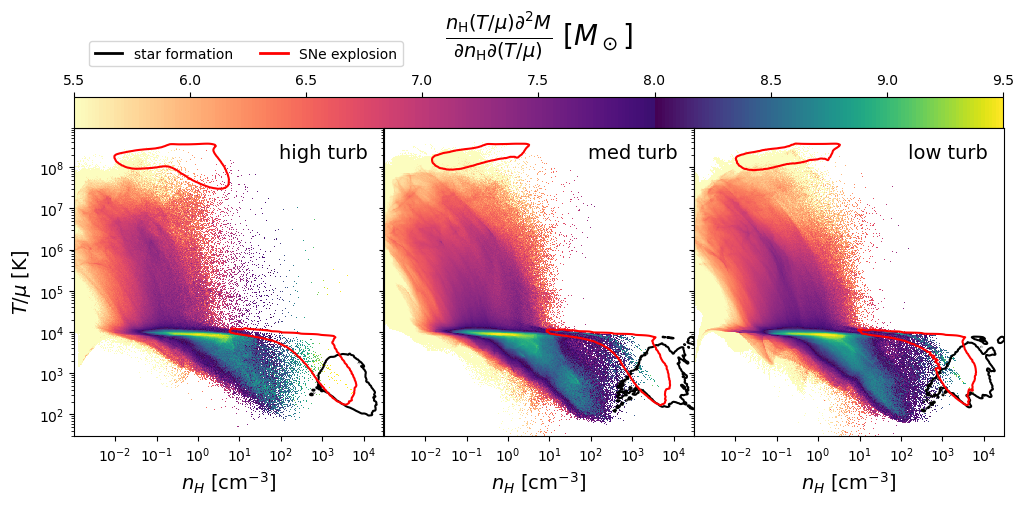

In [29]:
bottom, top = plt.colormaps['magma_r'], plt.colormaps['viridis']
custom_colors = np.vstack((bottom(np.linspace(0, 0.8, 10*16)), top(np.linspace(0, 1, 6*16))))
custom_cmp = ListedColormap(custom_colors, name='custom')

frac = 0.75
dx = 10*const.pc
sigma_list = [2, 1, 0, 3]
color_list = ['orange', 'black', 'red', 'orange']
label_list = ['high turb', 'med turb', 'low turb']

E_SNe = 1e51
m_SNe = 10*const.M_sol

fig, axs = plt.subplots(ncols=3, figsize=(12, 4), sharex=True, sharey=True)
plt.subplots_adjust(wspace=1e-3, hspace=1e-3)

for i in range(3):
    
    ax = axs[i]
    ax.set_xscale('log')
    ax.set_yscale('log')

    im = ax.pcolormesh(bin1_list[i, 0], bin2_list[i, 0], np.log10(hist_list[i, 0]/const.M_sol).T, vmin=5.5, vmax=9.5, cmap=custom_cmp)

    for j in [1, 2]:
    
        hist_sm = gaussian_filter(hist_list[i, j], sigma_list[j])
        field = hist_sm.flatten()
        idx_sorted = np.argsort(field)
        cumsum = np.cumsum(field[idx_sorted])
        level = field[idx_sorted[np.searchsorted(cumsum, (1-frac)*cumsum[-1])]]/const.M_sol
        ax.contour(bin1_list[i, j], bin2_list[i, j], hist_sm.T/const.M_sol, levels=[level], colors=color_list[j])

    if sne_list[i]:
        rho1d = bin1_list[i, 0]*const.m_p/const.X_cosmo+m_SNe/dx**3
        temp_SNe = const.m_p/const.k_B * (E_SNe/dx**3)/rho1d
        nH_crit = 100*(dx/(3*const.pc))**(0.42)
        
    ax.annotate(label_list[i], xy=(0.95, 0.95), xycoords='axes fraction', horizontalalignment='right', verticalalignment='top', fontsize=14)
        
axs[0].set_xlim(1e-3, 3e4)
axs[0].set_ylim(3e1, 9e8)
axs[0].set_xticks([1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4])
for i in range(3): axs[i].set_xlabel(r'$n_H$ [${\rm cm^{-3}}$]', fontsize=14)
axs[0].set_ylabel(r'$T/\mu$ [${\rm K}$]', fontsize=14)
    
cax = axs[0].inset_axes([0, 1, 3, 0.1])
cbar = plt.colorbar(im, cax=cax, orientation='horizontal')
cbar.set_label(r'$\frac{n_{\rm H} (T/\mu) \partial^2 M}{\partial n_{\rm H} \partial (T/\mu)}$ [$M_\odot$]', fontsize=20, labelpad=20)
cax.xaxis.set_ticks_position("top")
cax.xaxis.set_label_position("top")

cust_lines = [Line2D([0], [0], color=color, lw=2, linestyle='-') for color in ['black', 'red']]
axs[0].legend(cust_lines, [r'star formation', r'SNe explosion'], ncol=3, fontsize=10, loc=[0.05, 1.2])
    
save_fig('phaseall')
    